# Section 1: Clear GPU

In [ ]:
!nvidia-smi

Mon Dec 11 21:10:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |  40473MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo fuser -v /dev/nvidia*

!sudo kill -9  1325036

In [ ]:
!pip install captum

## Cleanup Disk

In [ ]:
!pwd
!cd /root/.cache/huggingface/
!ls

/
bin			    dev    libx32		     python-apt  tmp
boot			    etc    media		     root	 tools
content			    home   mnt			     run	 usr
cuda-keyring_1.0-1_all.deb  lib    NGC-DL-CONTAINER-LICENSE  sbin	 var
data			    lib32  opt			     srv
datalab			    lib64  proc			     sys


In [ ]:
ls hub

models--sgugger--rwkv-430M-pile/                    tmpy51klae6
models--togethercomputer--StripedHyena-Hessian-7B/  version.txt


In [ ]:
import os
import shutil

# Path to the cache directory
cache_dir = '/root/.cache/huggingface/hub/models--tiiuae--falcon-7b/'

# Check if the directory exists
if os.path.exists(cache_dir):
    # Delete the directory
    shutil.rmtree(cache_dir)
    print("Model weights deleted.")
else:
    print("Directory not found.")

Model weights deleted.


# Section 2: Mistral

## Setup Mistral

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
device = "cuda" # the device to load the model onto

In [ ]:
# this takes a very long time to run, once it works, don't mess with it.
mistral = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", output_attentions=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

In [ ]:
prompt = "The quick brown fox jumps over the lazy dog."

mistral_inputs = tokenizer([prompt], return_tensors="pt").to(device)
mistral.to(device)

generated_ids = mistral.generate(**mistral_inputs, max_new_tokens=100, do_sample=True)
print(tokenizer.batch_decode(generated_ids)[0])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> The quick brown fox jumps over the lazy dog.   This is an example that we use with our English students to teach the vowels of English.  Why the 26 vowels you may be asking?  Well the English language is one of the most complicated languages to master.  There’s a reason we have spell check and autocorrect as it seems that 70% of American’s would fail our English language and spelling classes.

What’s funny is that we seem to make sp


In [ ]:
print(mistral)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRM

## Getting embeddings

In [ ]:
embeddings = mistral.model.embed_tokens
layer_0 = mistral.model.layers[0].self_attn

In [ ]:
# just testing
embeddings(mistral_inputs[0])

tokenizer([''], return_tensors="pt")

TypeError: ignored

## Getting attention

In [ ]:
input=tokenizer([prompt], return_tensors="pt")['input_ids']
input=input.to(device)
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
def predict(input, attn_mask=None): # takes tokenized input
  return mistral.model(input, attention_mask=attn_mask).attentions

def pos_forward(input, attn_mask=None):
  output = mistral.model(input, attention_mask=attn_mask)
  return output[position].max(1).values

In [ ]:
indices = input[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)
output_attn_mistral = predict(input)

In [ ]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
output_attn_all_mistral = torch.stack(output_attn_mistral)

In [ ]:
torch.save(output_attn_all_mistral, 'mistral_attn.pt')

## Visualization

In [ ]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 100))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(len(scores_mat)//3+1, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

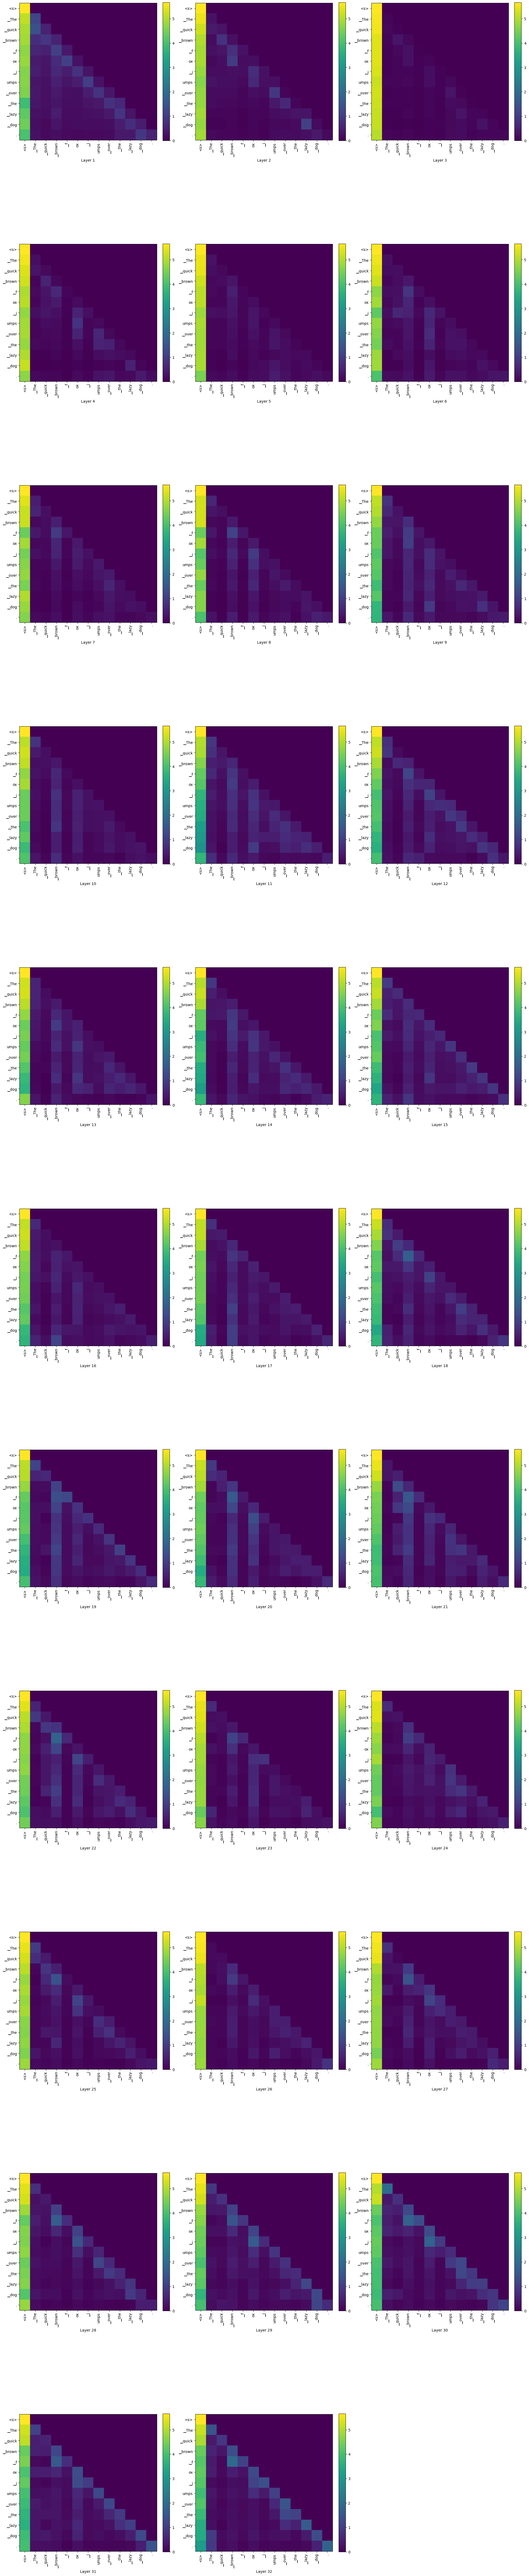

In [ ]:
output_attn_all_mistral = torch.load('mistral_attn.pt', map_location=torch.device(device))
visualize_token2token_scores(norm_fn(output_attn_all_mistral, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

## Visualization by Layer

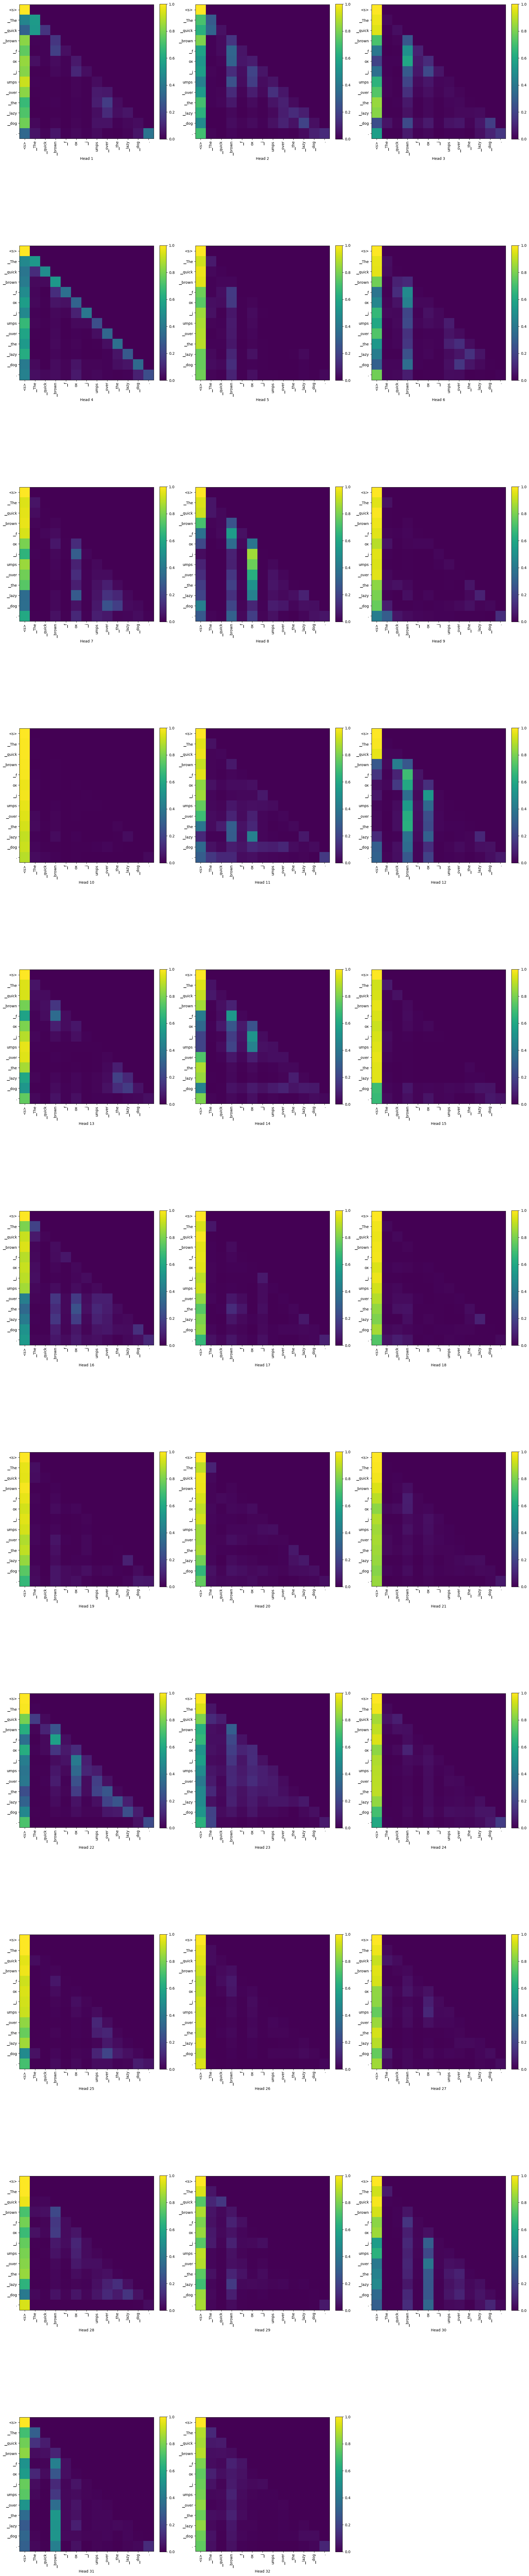

In [ ]:
layer=19
visualize_token2token_scores(output_attn_all_mistral[layer].squeeze().detach().cpu().numpy())

# Section 3: Falcon

## Setup Falcon


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
device='cuda'

In [114]:
# this takes a very long time to run, once it works, don't mess with it.
falcon = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-7b", output_attentions=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [115]:
tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")

In [117]:
prompt = "The quick brown fox jumps over the lazy dog."

falcon_inputs = tokenizer([prompt], return_tensors="pt").to(device)
falcon.to(device)

generated_ids = falcon.generate(**falcon_inputs, max_new_tokens=100, do_sample=True)
print(tokenizer.batch_decode(generated_ids)[0])

OutOfMemoryError: ignored

## Getting attention

In [ ]:
print(falcon)

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(65024, 4544)
    (h): ModuleList(
      (0-31): 32 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (maybe_rotary): FalconRotaryEmbedding()
          (query_key_value): FalconLinear(in_features=4544, out_features=4672, bias=False)
          (dense): FalconLinear(in_features=4544, out_features=4544, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): FalconLinear(in_features=4544, out_features=18176, bias=False)
          (act): GELU(approximate='none')
          (dense_4h_to_h): FalconLinear(in_features=18176, out_features=4544, bias=False)
        )
        (input_layernorm): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4544, out_features=65024, bias=False)
)


In [ ]:
input=tokenizer([prompt], return_tensors="pt")['input_ids']
input=input.to(device)

def predict(input, attn_mask=None): # takes tokenized input
  return falcon.transformer(input, attention_mask=attn_mask).attentions

output_attn_falcon = predict(input)

if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
output_attn_all_falcon = torch.stack(output_attn_falcon)

indices = input[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

torch.save(output_attn_all_falcon, 'falcon_attn.pt')

In [ ]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

## Visualization

In [ ]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 100))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(len(scores_mat)//3+1, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_token2token_scores(norm_fn(output_attn_all_falcon, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

## Visualization by Layer

In [ ]:
layer = 19
visualize_token2token_scores(output_attn_falcon[layer].squeeze().detach().cpu().numpy())

# Section 4: BERT

## Setup BERT

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

In [ ]:
device='cuda'

In [ ]:
bert = BertForQuestionAnswering.from_pretrained("bert-large-uncased", output_attentions=True)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

In [ ]:
prompt = "The quick brown fox jumps over the lazy dog."

bert_inputs = tokenizer([prompt], return_tensors="pt").to(device)
bert.to(device)
bert.eval()
bert.zero_grad()

In [ ]:
generated_ids = bert.generate(**bert_inputs, max_new_tokens=100, do_sample=True)
print(tokenizer.batch_decode(generated_ids)[0])

## Getting Attention

In [ ]:
print(bert)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

In [ ]:
input=tokenizer([prompt], return_tensors="pt")['input_ids']
input=input.to(device)

In [ ]:
def predict(inputs, attention_mask=None):
    output = bert(inputs, attention_mask=attention_mask)
    return output.attentions

In [ ]:
output_attn_bert = predict(input)

if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
output_attn_all_bert = torch.stack(output_attn_bert)

indices = input[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

torch.save(output_attn_all_bert, 'bert_attn_large.pt')

In [ ]:
output_attn_all_bert.shape

torch.Size([12, 1, 12, 12, 12])

## Visualization

In [ ]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20,100))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(len(scores_mat)//3+1, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

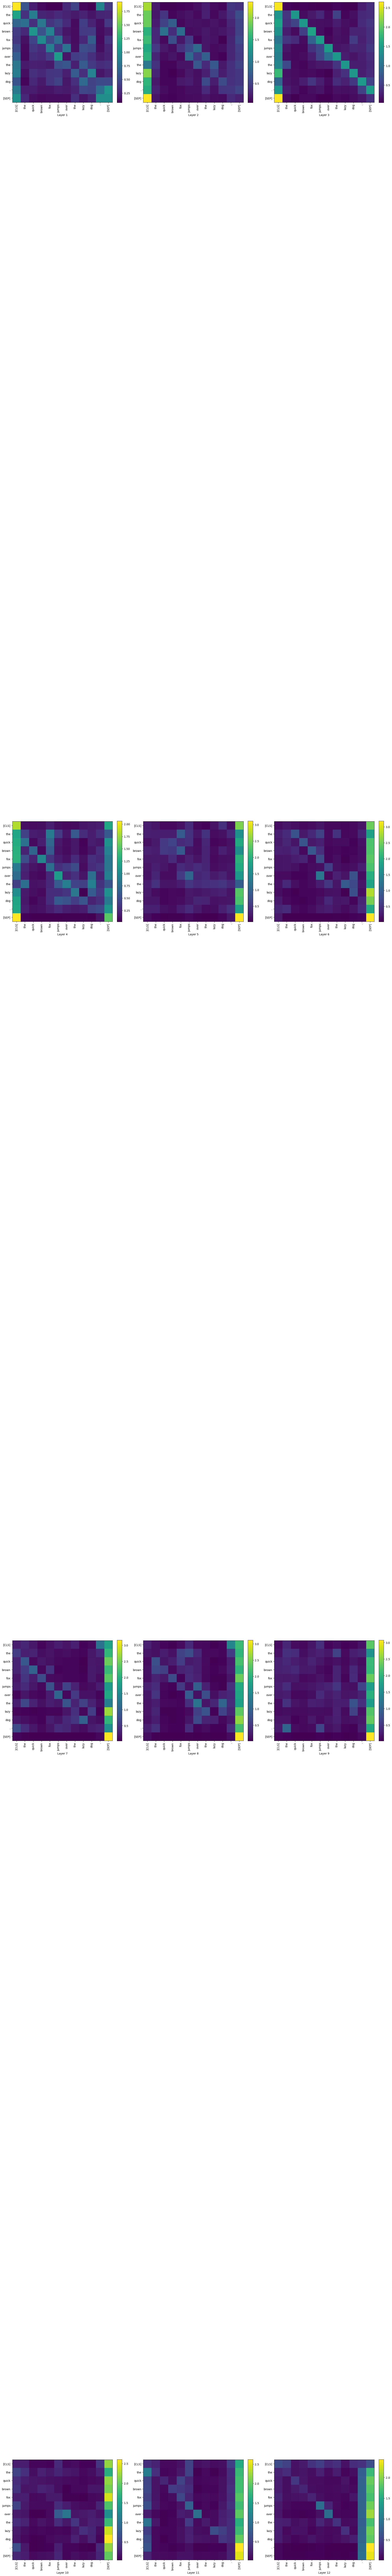

In [ ]:
visualize_token2token_scores(norm_fn(output_attn_all_bert, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

## Visualization by Layer

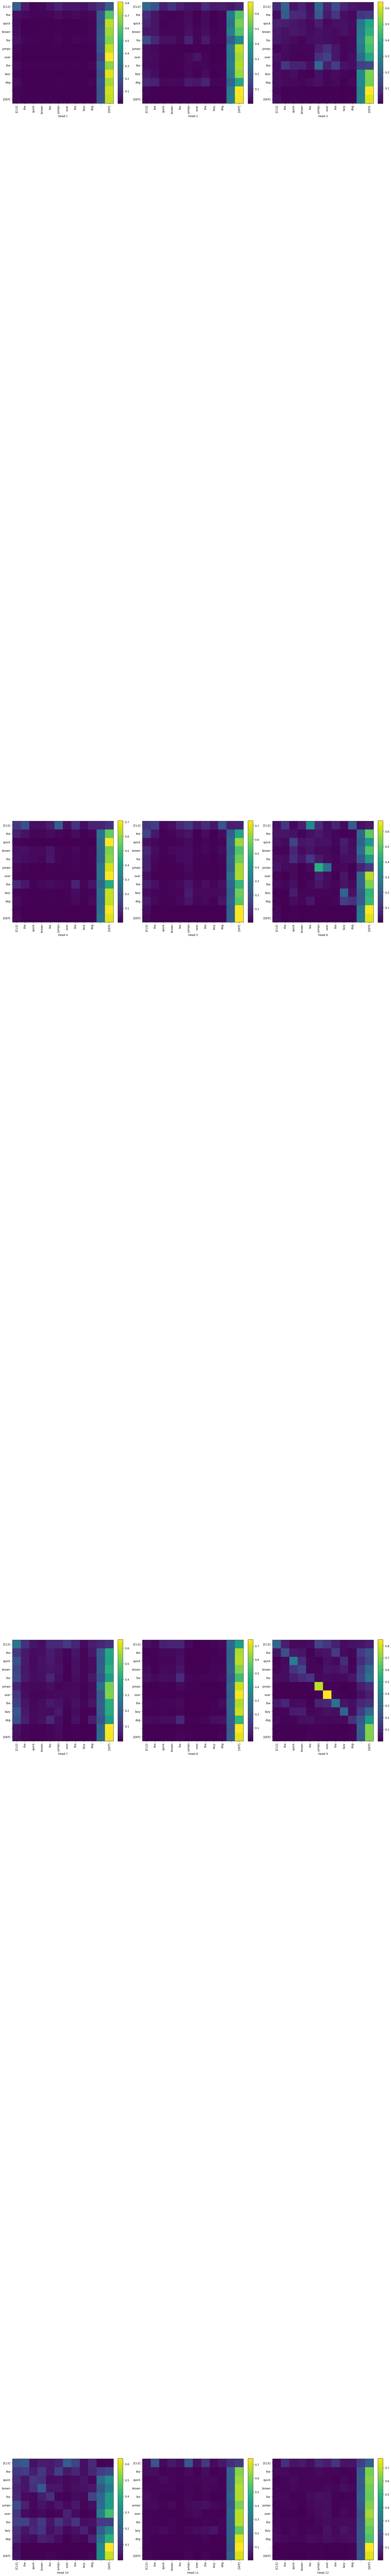

In [ ]:
layer = 11
visualize_token2token_scores(output_attn_bert[layer].squeeze().detach().cpu().numpy())

#Section 5:Flan-T5

## Setup Flan T5

In [ ]:
# pip install accelerate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")
t5model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", output_attentions=True, output_hidden_states = True )

device='cuda'
t5model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
prompt = "The quick brown fox jumps over the lazy dog."
inputs =  tokenizer(prompt, return_tensors="pt").to(device)
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

In [ ]:
generated_ids = t5model.generate(**inputs, max_new_tokens=100, do_sample=True)
print(tokenizer.batch_decode(generated_ids)[0])

<pad> The fox gets the treats.</s>


## Getting Attentions

In [ ]:
input

tensor([[11340,   138,    19,     8, 20811,    13,  2154,    63,     7,  1024,
             5,   555,   706,     6,     3,    88,  1432,     7,   160,    95,
            11,     1]], device='cuda:0')

In [ ]:
inputs

{'input_ids': tensor([[   37,  1704,  4216,     3, 20400,  4418,     7,   147,     8, 19743,
          1782,     5,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
def predict(input, attn_mask=None): # takes tokenized input
  output=t5model(input_ids=input_ids, decoder_input_ids=input_ids)
  return output.encoder_attentions + output.decoder_attentions

output_attn_t5 = predict(input_ids)

if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

output_attn_all_t5 = torch.stack(output_attn_t5)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

torch.save(output_attn_all_t5, 't5_attn.pt')

## Visualization

In [ ]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
  fig = plt.figure(figsize=(20,100))

  for idx, scores in enumerate(scores_mat):
      scores_np = np.array(scores)
      ax = fig.add_subplot(len(scores_mat)//3+1, 3, idx+1)
      # append the attention weights
      im = ax.imshow(scores, cmap='viridis')

      fontdict = {'fontsize': 10}

      ax.set_xticks(range(len(all_tokens)))
      ax.set_yticks(range(len(all_tokens)))

      ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
      ax.set_yticklabels(all_tokens, fontdict=fontdict)
      ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

      fig.colorbar(im, fraction=0.046, pad=0.04)
  plt.tight_layout()
  plt.show()

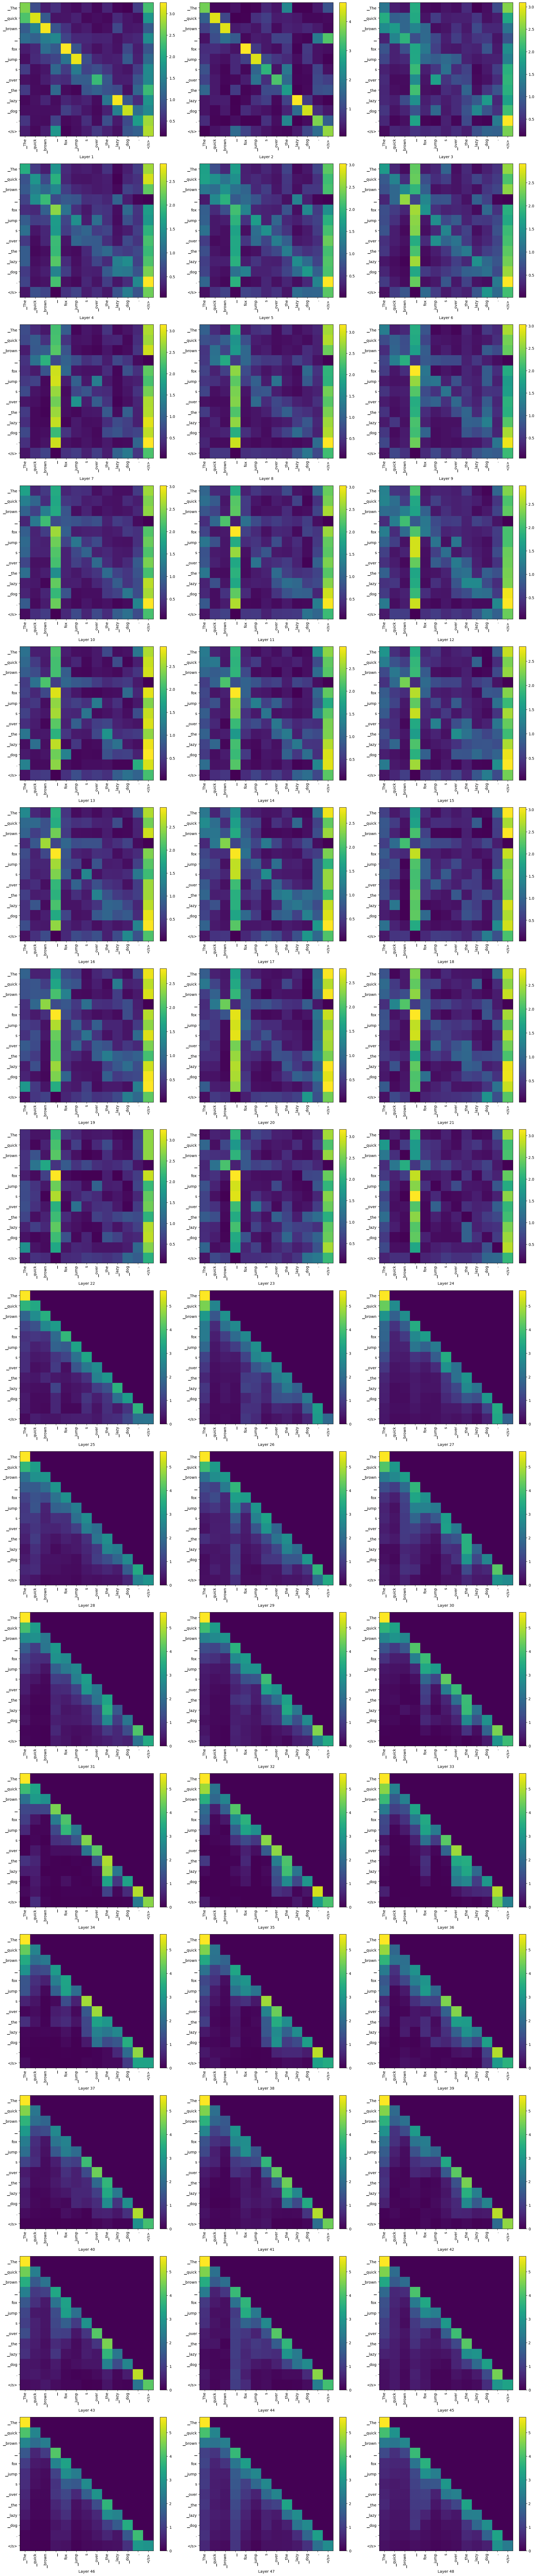

In [ ]:
visualize_token2token_scores(norm_fn(output_attn_all_t5, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

## Visualize by layer

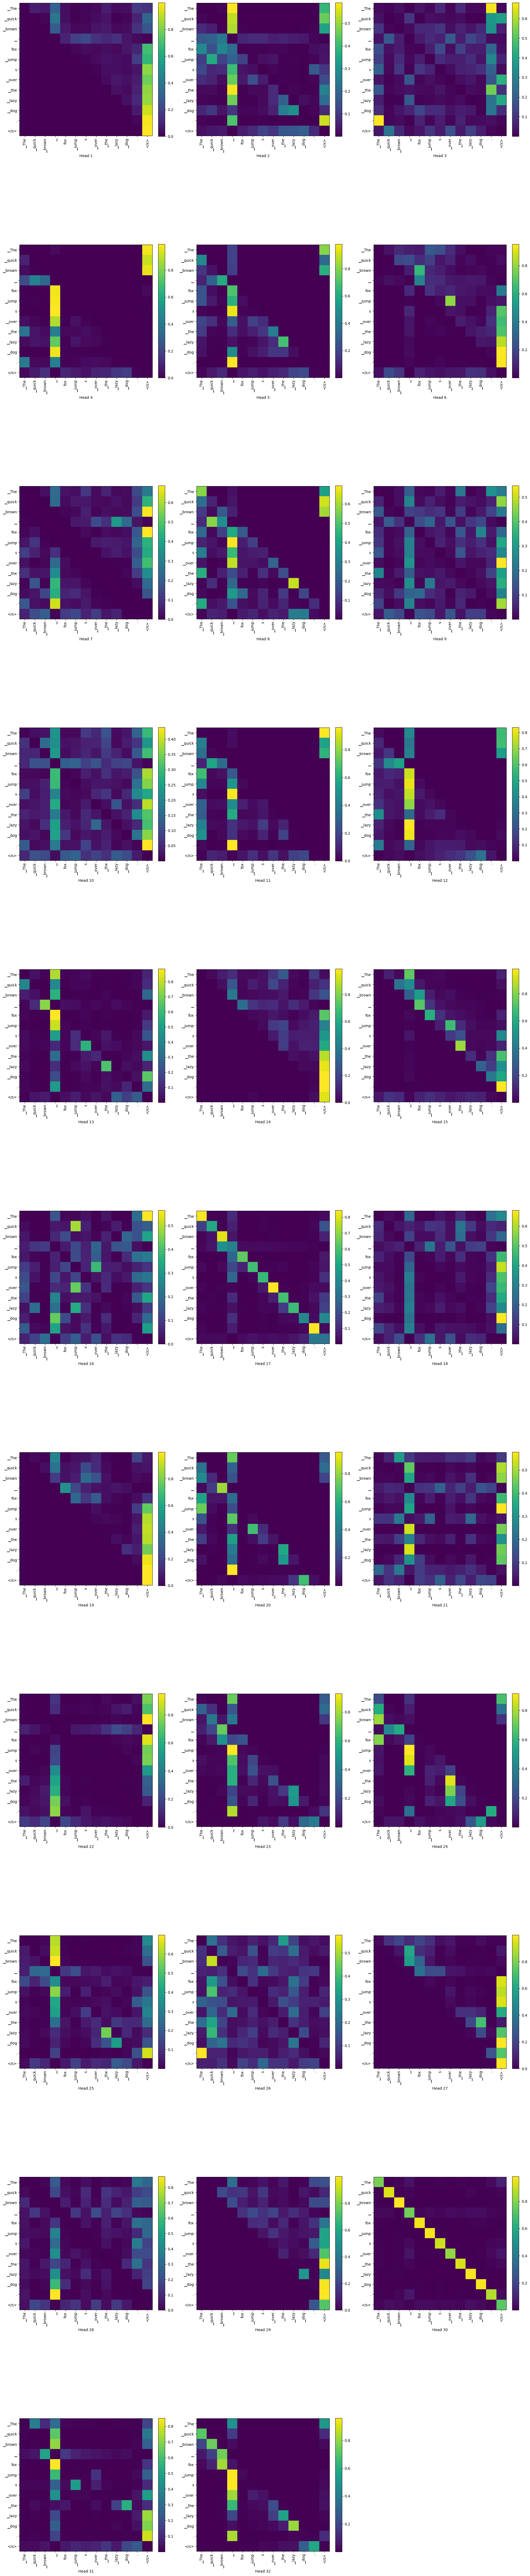

In [ ]:
layer = 11
visualize_token2token_scores(output_attn_t5[layer].squeeze().detach().cpu().numpy())

# Section 6: Sparsity Calculations

In [97]:
def calculate_sparsity(attention_map):
    # Count the number of elements less than the threshold
    sparsities = []
    for layer in attention_map:
      layer=torch.squeeze(norm_fn(layer, dim=1))
      layer = torch.tril(layer)
      threshold = torch.mean(layer)
      sparse_elements = (layer < threshold).float()
      sparsity = sparse_elements.mean().item()
      sparsities.append(sparsity)  # Calculate the mean to get the fraction of sparse elements
    return sparsities

In [98]:
def calculate_sparsity_rwkv(attention_map):
    # Count the number of elements less than the threshold
    sparsities = []
    for layer in attention_map:
      layer=torch.squeeze(norm_fn(layer, dim=1))
      # layer = torch.tril(layer)
      threshold = torch.mean(layer)
      sparse_elements = (layer < threshold).float()
      sparsity = sparse_elements.mean().item()
      sparsities.append(sparsity)  # Calculate the mean to get the fraction of sparse elements
    return sparsities

In [ ]:
def calculate_nonzero(attention_map):
    # Count the number of elements less than the threshold
    sparsities = []
    for layer in attention_map:
      layer=torch.squeeze(layer)
      std,mean=torch.std_mean(torch.tril(layer))
      sparse_elements = (layer > mean-2*std).float()
      print(sparse_elements)
      print()
      sparsity = sparse_elements.mean().item()
      sparsities.append(sparsity)  # Calculate the mean to get the fraction of sparse elements
    return sparsities

In [77]:
device='cuda'
mistral_attn = torch.load('mistral_attn.pt', map_location=torch.device(device))
falcon_attn = torch.load('falcon_attn.pt', map_location=torch.device(device))
bert_attn = torch.load('bert_attn_large.pt', map_location=torch.device(device))
t5_attn = torch.load('t5_attn.pt', map_location=torch.device(device))

In [78]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

falcon_normed=norm_fn(torch.squeeze(falcon_attn), dim=1)
mistral_normed=norm_fn(torch.squeeze(mistral_attn), dim=1)
bert_normed=norm_fn(torch.squeeze(bert_attn), dim=1)
t5_normed=norm_fn(torch.squeeze(t5_attn), dim=1)

In [79]:
import warnings
warnings.filterwarnings('ignore')

In [103]:
def sparsity_sd_mean(attn_map, is_rwkv=False):
  if is_rwkv:
    sparsity=torch.tensor(calculate_sparsity_rwkv(attn_map))
  else:
    sparsity=torch.tensor(calculate_sparsity(attn_map))
  return torch.std_mean(sparsity)

In [104]:
print(sparsity_sd_mean(mistral_attn))
print(sparsity_sd_mean(falcon_attn))
print(sparsity_sd_mean(bert_attn))
print(sparsity_sd_mean(t5_attn))
print(sparsity_sd_mean(rwkv_attn, is_rwkv=True))

(tensor(0.0427), tensor(0.8308))
(tensor(0.0538), tensor(0.8269))
(tensor(0.0568), tensor(0.6950))
(tensor(0.0403), tensor(0.7089))
(tensor(0.0303), tensor(0.6392))


## Plotting JS Divergence Mistral

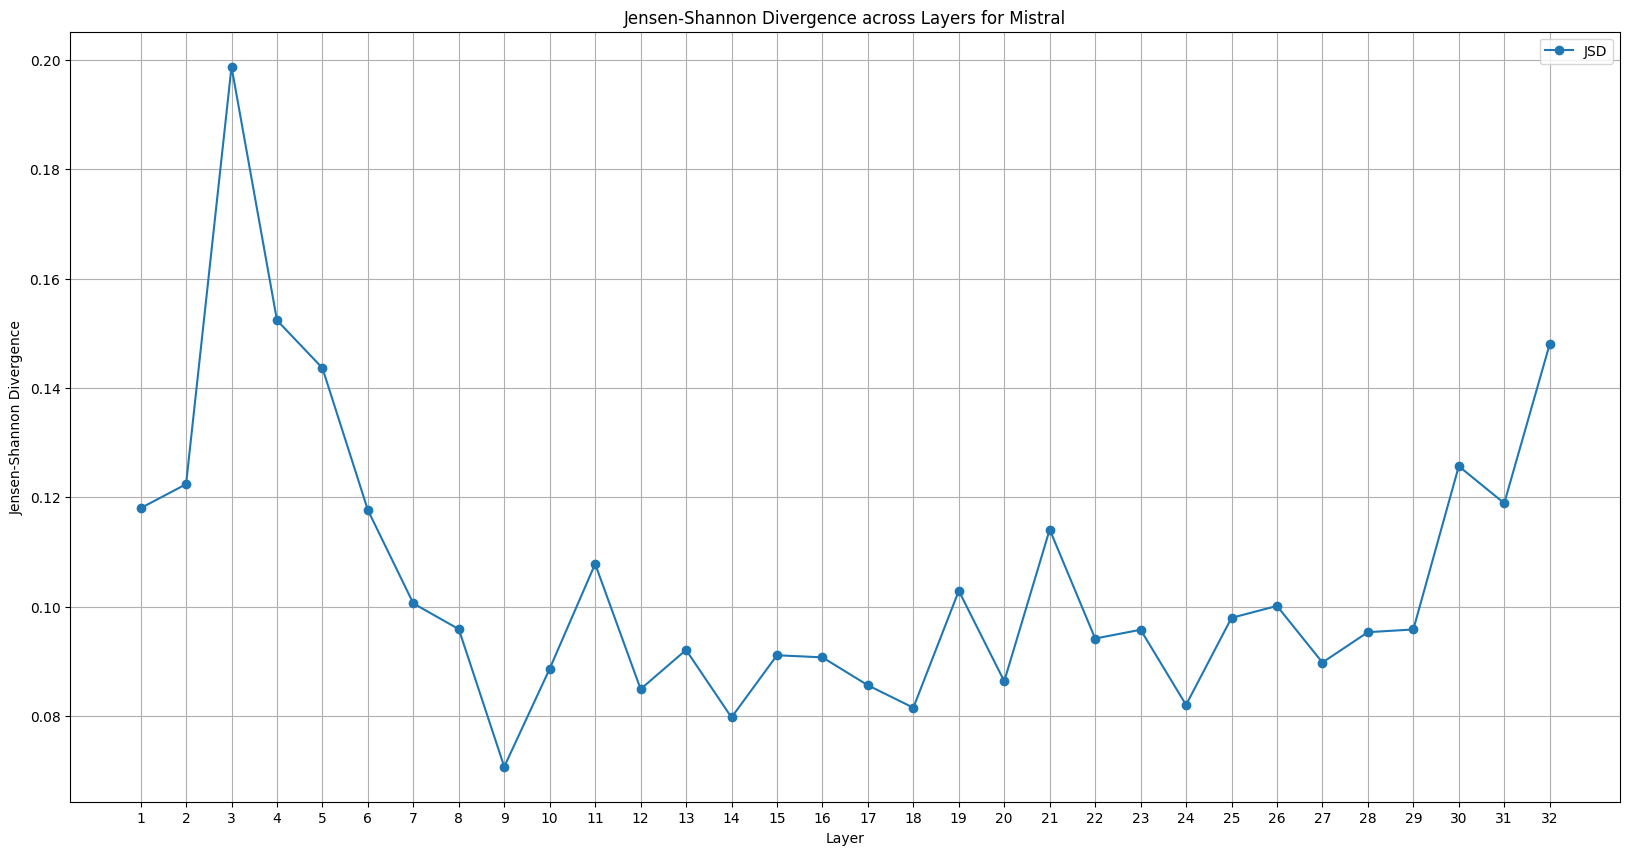

In [ ]:
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def calculate_js_divergence(map1, map2):
    # Flatten and normalize the attention maps to create probability distributions
    p = map1.flatten()
    p_norm = p/torch.sum(p) # p.sum()
    q = map2.flatten()
    q_norm = q/torch.sum(q) #q.sum()

    # Calculate the Jensen-Shannon divergence
    return jensenshannon(p_norm.detach().cpu().numpy(), q_norm.detach().cpu().numpy())

# Example usage:
# Assuming attention_maps is a list of your attention map tensors
# attention_maps = [layer1_map, layer2_map, ..., layer32_map]

# Select a reference map (e.g., first layer or an average map)
reference_map = torch.mean(mistral_normed, dim=0)

# Calculate the JS divergence for each layer
js_divergences = [calculate_js_divergence(reference_map, map_i) for map_i in mistral_normed]
# js_divergences = [calculate_js_divergence(falc,mist) for falc,mist in zip(falcon_normed, mistral_normed)]

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(js_divergences, marker='o')  # Using a marker for better visibility
plt.xlabel('Layer')
plt.ylabel('Jensen-Shannon Divergence')
plt.xticks(range(len(js_divergences)), [f'{i+1}' for i in range(len(js_divergences))])
plt.title('Jensen-Shannon Divergence across Layers for Mistral')
plt.legend(['JSD'])
plt.grid(True)
plt.show()

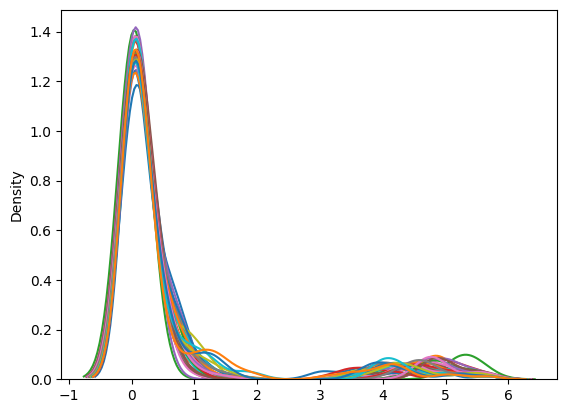

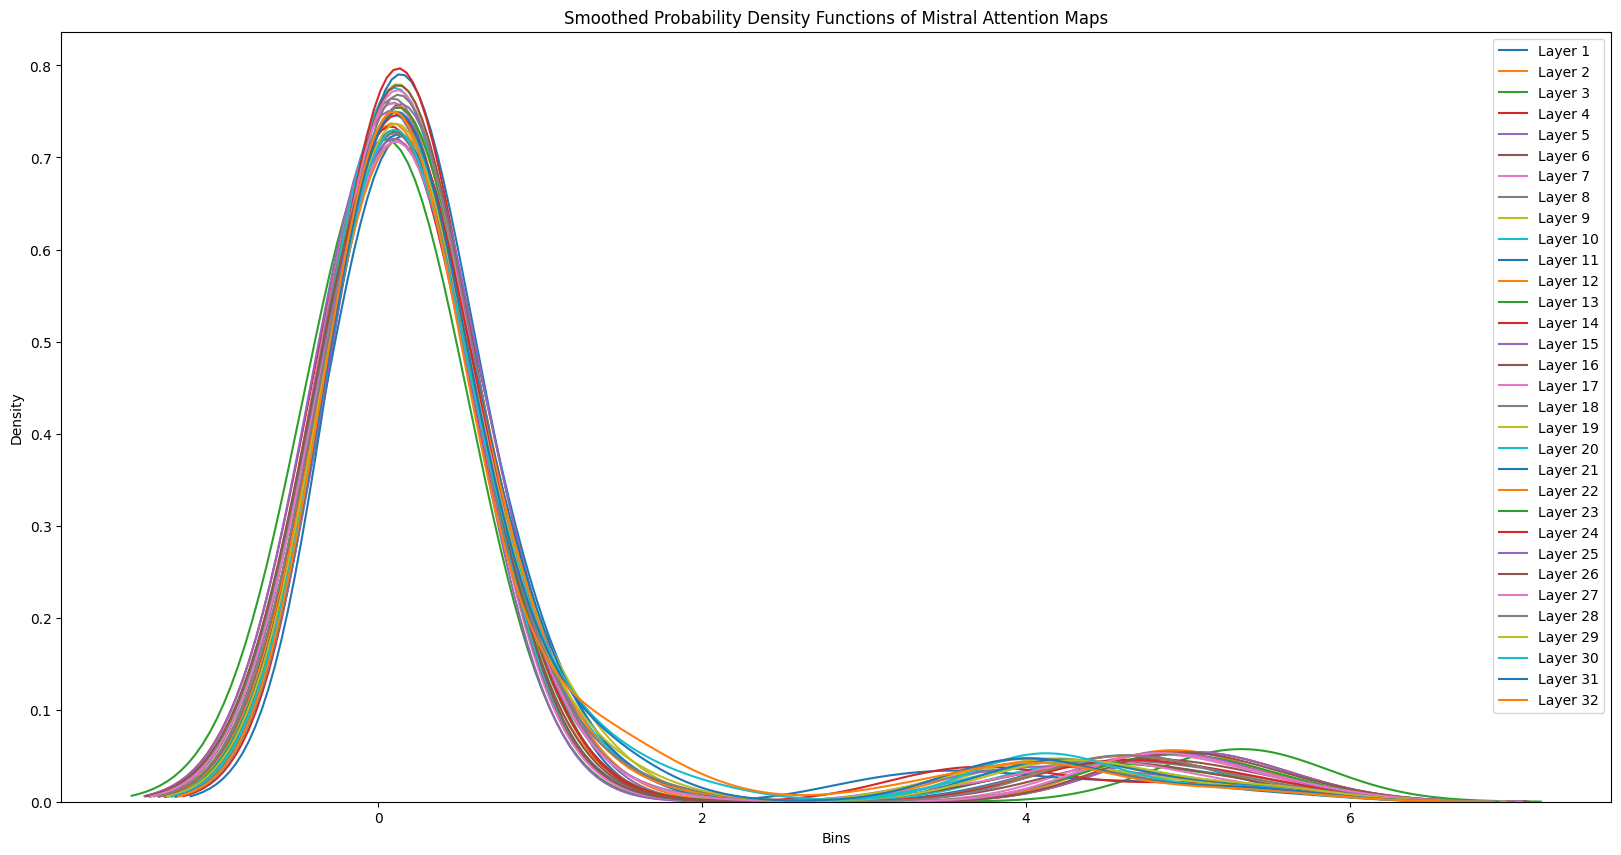

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# Assuming attention_maps is a list of attention map tensors for each layer
# Convert the list of tensors to numpy arrays and flatten them
flattened_maps = [map_tensor.detach().cpu().numpy().flatten() for map_tensor in mistral_normed]

# Calculate PDF using Kernel Density Estimation for each layer
kde_list = [sns.kdeplot(map_array, bw_adjust=0.5, fill=False) for map_array in flattened_maps]

# Calculate JSD between each pair of layers (if needed)
jsd_matrix = np.zeros((len(flattened_maps), len(flattened_maps)))
for i in range(len(flattened_maps)):
    for j in range(i+1, len(flattened_maps)):
        jsd_matrix[i, j] = jensenshannon(flattened_maps[i], flattened_maps[j])

# Since JSD is symmetric, copy the upper triangle to the lower triangle
jsd_matrix = jsd_matrix + jsd_matrix.T

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
for i, kde in enumerate(kde_list):
    sns.kdeplot(flattened_maps[i], ax=ax, fill=False, common_norm=False, palette="crest", label=f'Layer {i+1}')
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend()
plt.title('Smoothed Probability Density Functions of Mistral Attention Maps')
plt.show()

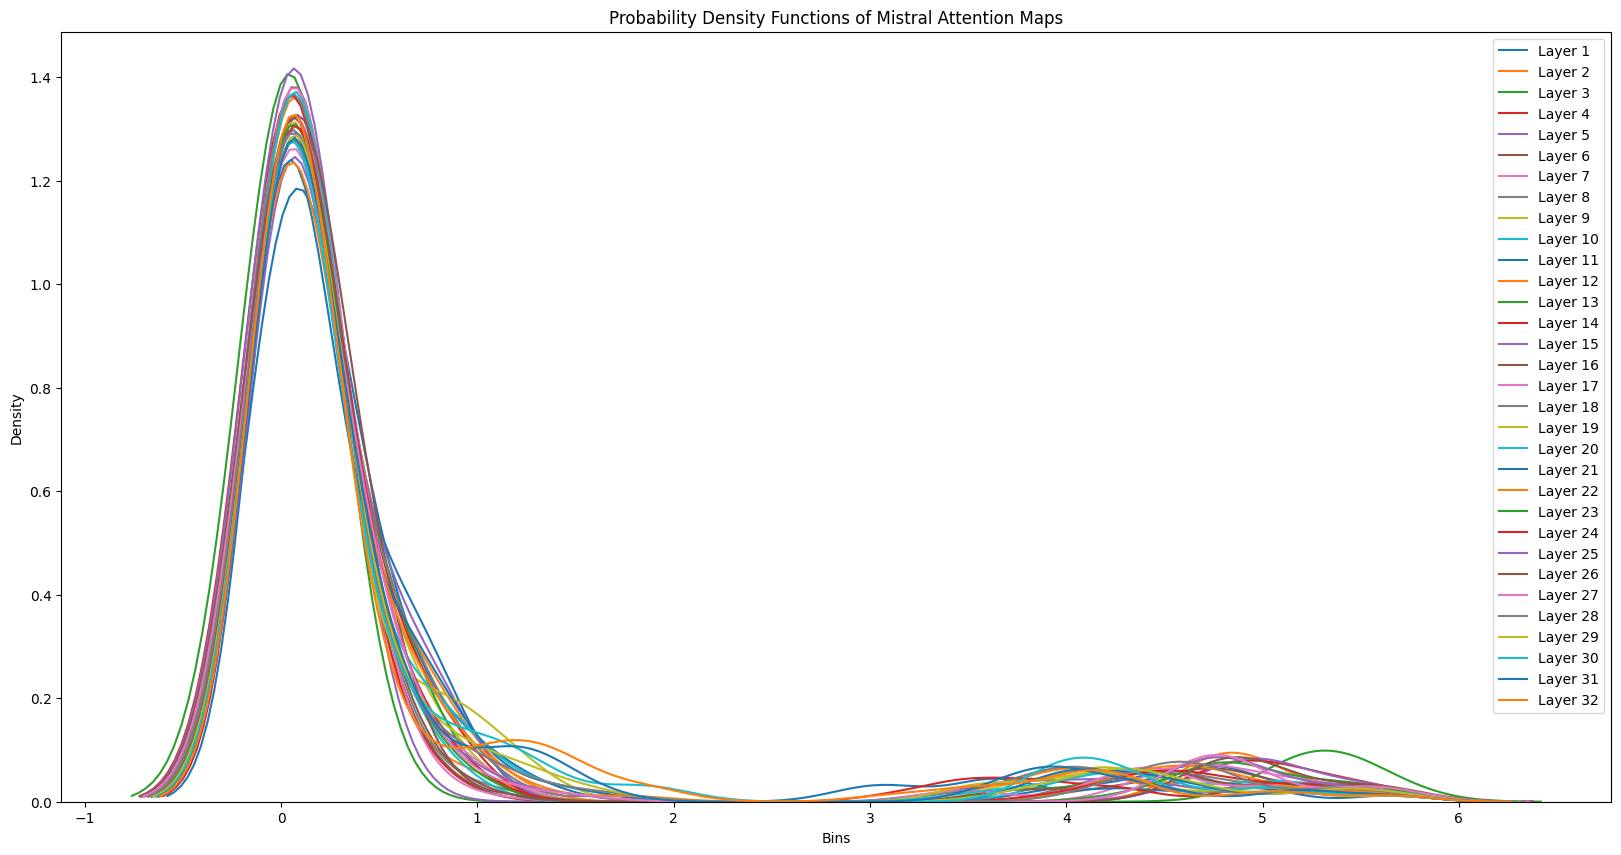

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
for i,map_array in enumerate(flattened_maps):
  sns.kdeplot(map_array, bw_adjust=0.5, ax=ax, fill=False, common_norm=False, palette="crest", label=f'Layer {i+1}')
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend()
plt.title('Probability Density Functions of Mistral Attention Maps')
plt.show()

## Plotting JS Divergence Falcon


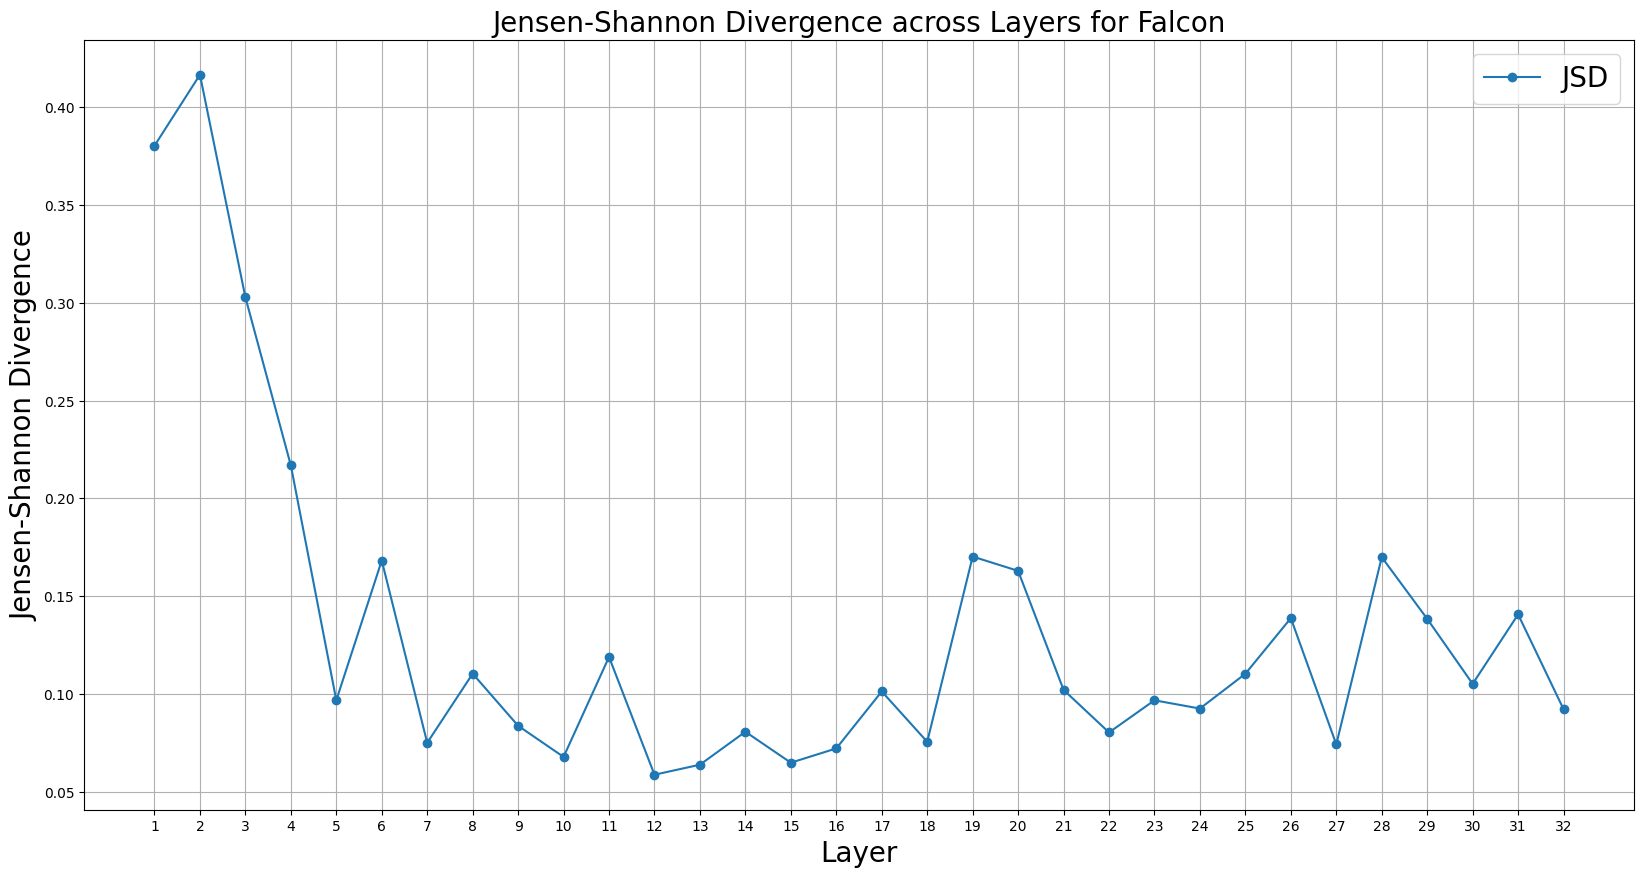

In [ ]:
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def calculate_js_divergence(map1, map2):
    # Flatten and normalize the attention maps to create probability distributions
    p = map1.flatten()
    p_norm = p/torch.sum(p) # p.sum()
    q = map2.flatten()
    q_norm = q/torch.sum(q) #q.sum()

    # Calculate the Jensen-Shannon divergence
    return jensenshannon(p_norm.detach().cpu().numpy(), q_norm.detach().cpu().numpy())

# Example usage:
# Assuming attention_maps is a list of your attention map tensors
# attention_maps = [layer1_map, layer2_map, ..., layer32_map]

# Select a reference map (e.g., first layer or an average map)
reference_map = torch.mean(falcon_normed, dim=0)

# Calculate the JS divergence for each layer
js_divergences = [calculate_js_divergence(reference_map, map_i) for map_i in falcon_normed]
# js_divergences = [calculate_js_divergence(falc,mist) for falc,mist in zip(falcon_normed, mistral_normed)]

# Plotting
fsize=20
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(js_divergences, marker='o')  # Using a marker for better visibility
plt.xlabel('Layer',fontsize=fsize)
plt.ylabel('Jensen-Shannon Divergence',fontsize=fsize)
plt.xticks(range(len(js_divergences)), [f'{i+1}' for i in range(len(js_divergences))])
plt.title('Jensen-Shannon Divergence across Layers for Falcon',fontsize=fsize)
plt.legend(['JSD'],fontsize=fsize)
plt.grid(True)
plt.show()

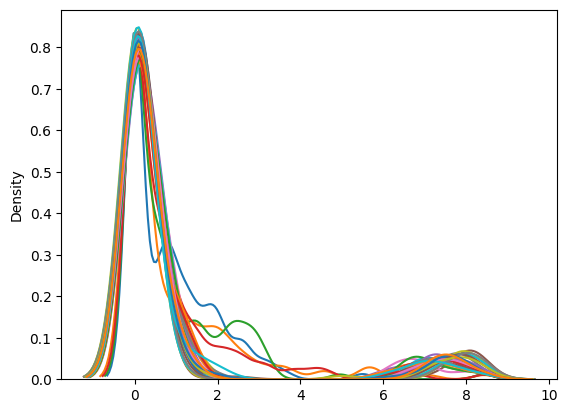

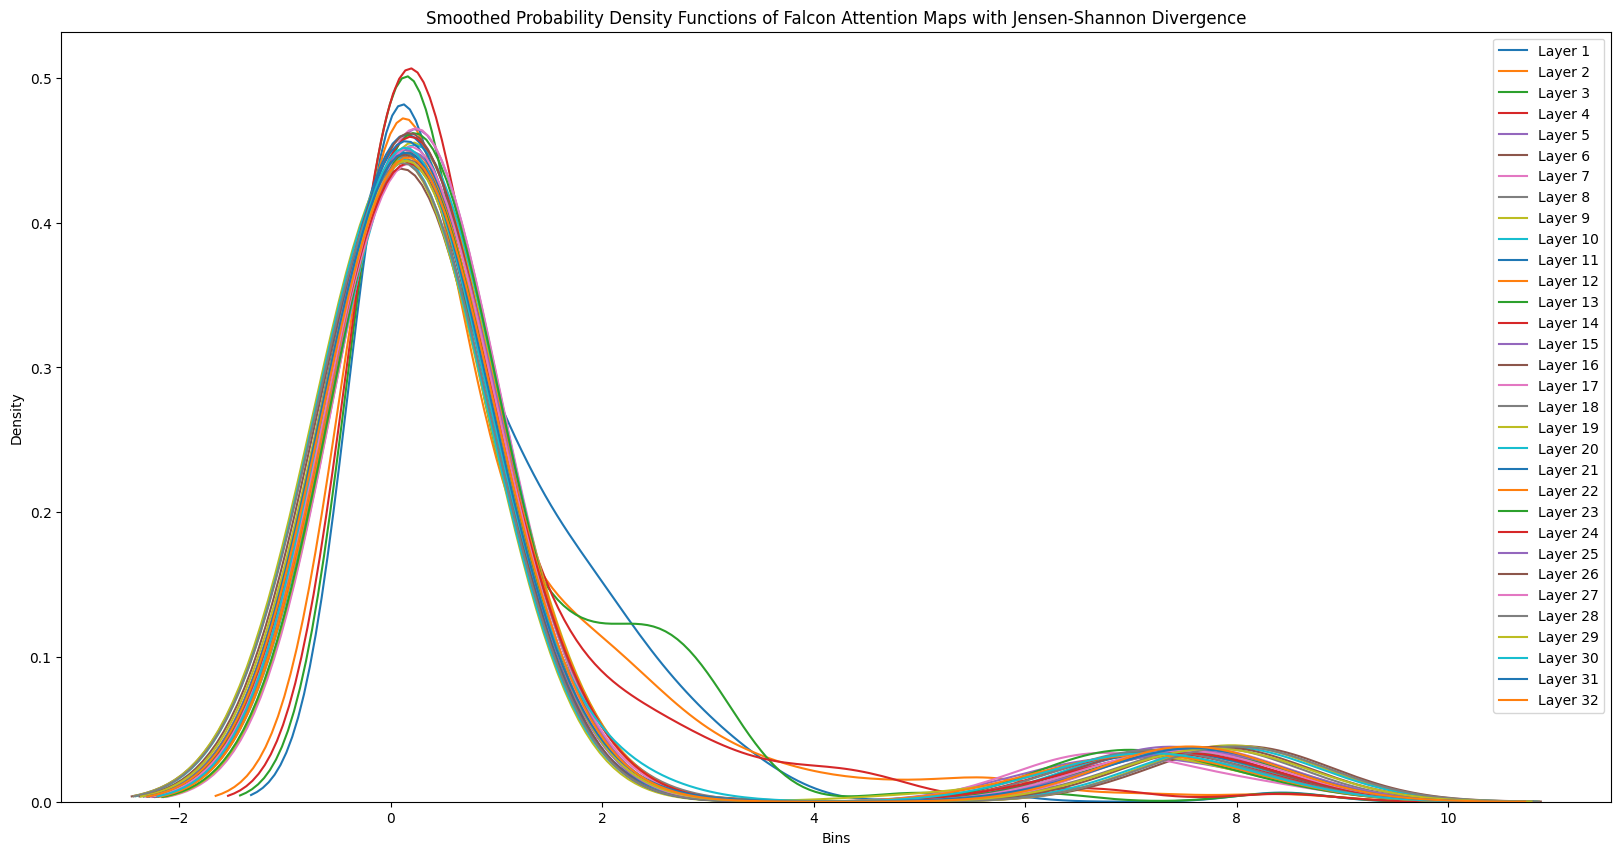

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# Assuming attention_maps is a list of attention map tensors for each layer
# Convert the list of tensors to numpy arrays and flatten them
flattened_maps = [map_tensor.detach().cpu().numpy().flatten() for map_tensor in falcon_normed]

# Calculate PDF using Kernel Density Estimation for each layer
kde_list = [sns.kdeplot(map_array, bw_adjust=0.5, fill=False) for map_array in flattened_maps]

# Calculate JSD between each pair of layers (if needed)
jsd_matrix = np.zeros((len(flattened_maps), len(flattened_maps)))
for i in range(len(flattened_maps)):
    for j in range(i+1, len(flattened_maps)):
        jsd_matrix[i, j] = jensenshannon(flattened_maps[i], flattened_maps[j])

# Since JSD is symmetric, copy the upper triangle to the lower triangle
jsd_matrix = jsd_matrix + jsd_matrix.T

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))
for i, kde in enumerate(kde_list):
    sns.kdeplot(flattened_maps[i], ax=ax, fill=False, common_norm=False, palette="crest", label=f'Layer {i+1}')
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend()
plt.title('Smoothed Probability Density Functions of Falcon Attention Maps with Jensen-Shannon Divergence')
plt.show()

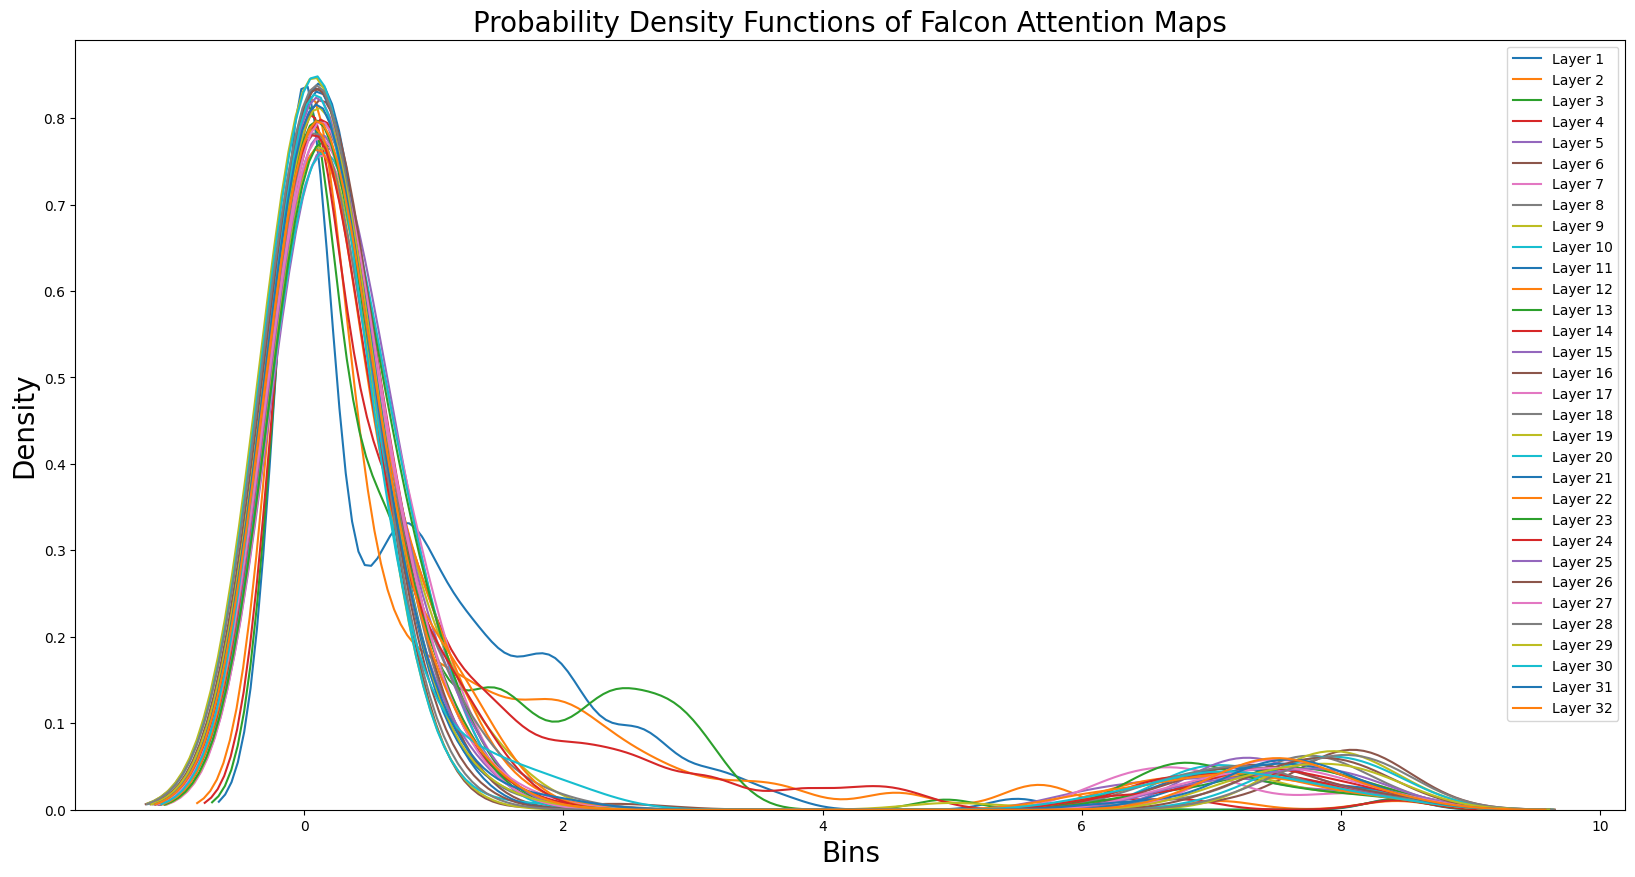

In [ ]:
fsize=20
fig, ax = plt.subplots(figsize=(20, 10))
for i,map_array in enumerate(flattened_maps):
  sns.kdeplot(map_array, bw_adjust=0.5, ax=ax, fill=False, common_norm=False, palette="crest", label=f'Layer {i+1}')
plt.xlabel('Bins',fontsize=fsize)
plt.ylabel('Density',fontsize=fsize)
plt.legend()
plt.title('Probability Density Functions of Falcon Attention Maps',fontsize=fsize)
plt.show()

## Plotting JS Divergence Bert

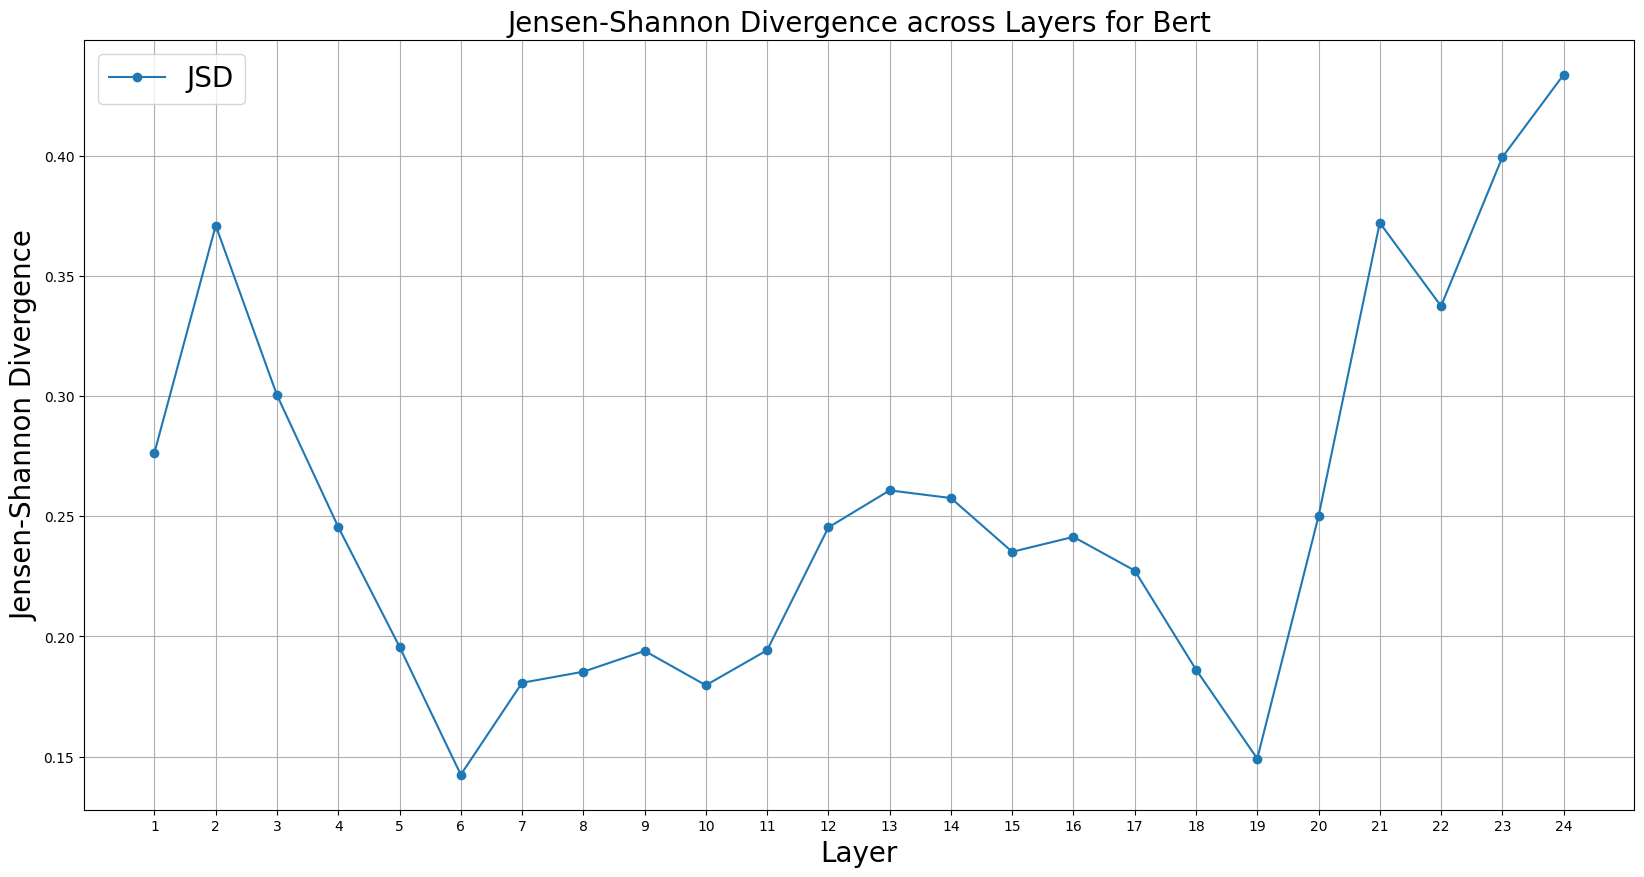

In [ ]:
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def calculate_js_divergence(map1, map2):
    # Flatten and normalize the attention maps to create probability distributions
    p = map1.flatten()
    p_norm = p/torch.sum(p) # p.sum()
    q = map2.flatten()
    q_norm = q/torch.sum(q) #q.sum()

    # Calculate the Jensen-Shannon divergence
    return jensenshannon(p_norm.detach().cpu().numpy(), q_norm.detach().cpu().numpy())

# Example usage:
# Assuming attention_maps is a list of your attention map tensors
# attention_maps = [layer1_map, layer2_map, ..., layer32_map]

# Select a reference map (e.g., first layer or an average map)
reference_map = torch.mean(bert_normed, dim=0)

# Calculate the JS divergence for each layer
js_divergences = [calculate_js_divergence(reference_map, map_i) for map_i in bert_normed]

# Plotting
fsize=20
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(js_divergences, marker='o')  # Using a marker for better visibility
plt.xlabel('Layer', fontsize=fsize)
plt.ylabel('Jensen-Shannon Divergence', fontsize=fsize)
plt.xticks(range(len(js_divergences)), [f'{i+1}' for i in range(len(js_divergences))])
plt.title('Jensen-Shannon Divergence across Layers for Bert', fontsize=fsize)
plt.legend(['JSD'], fontsize=fsize)
plt.grid(True)
plt.show()

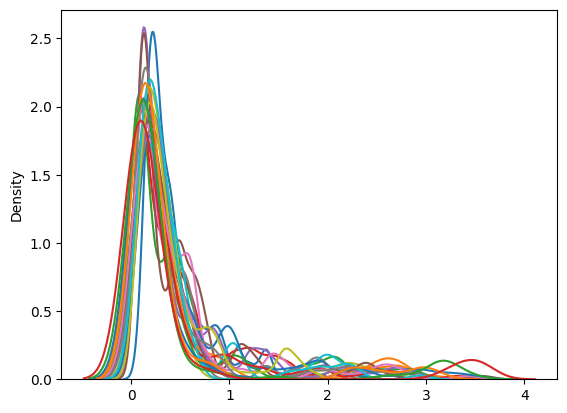

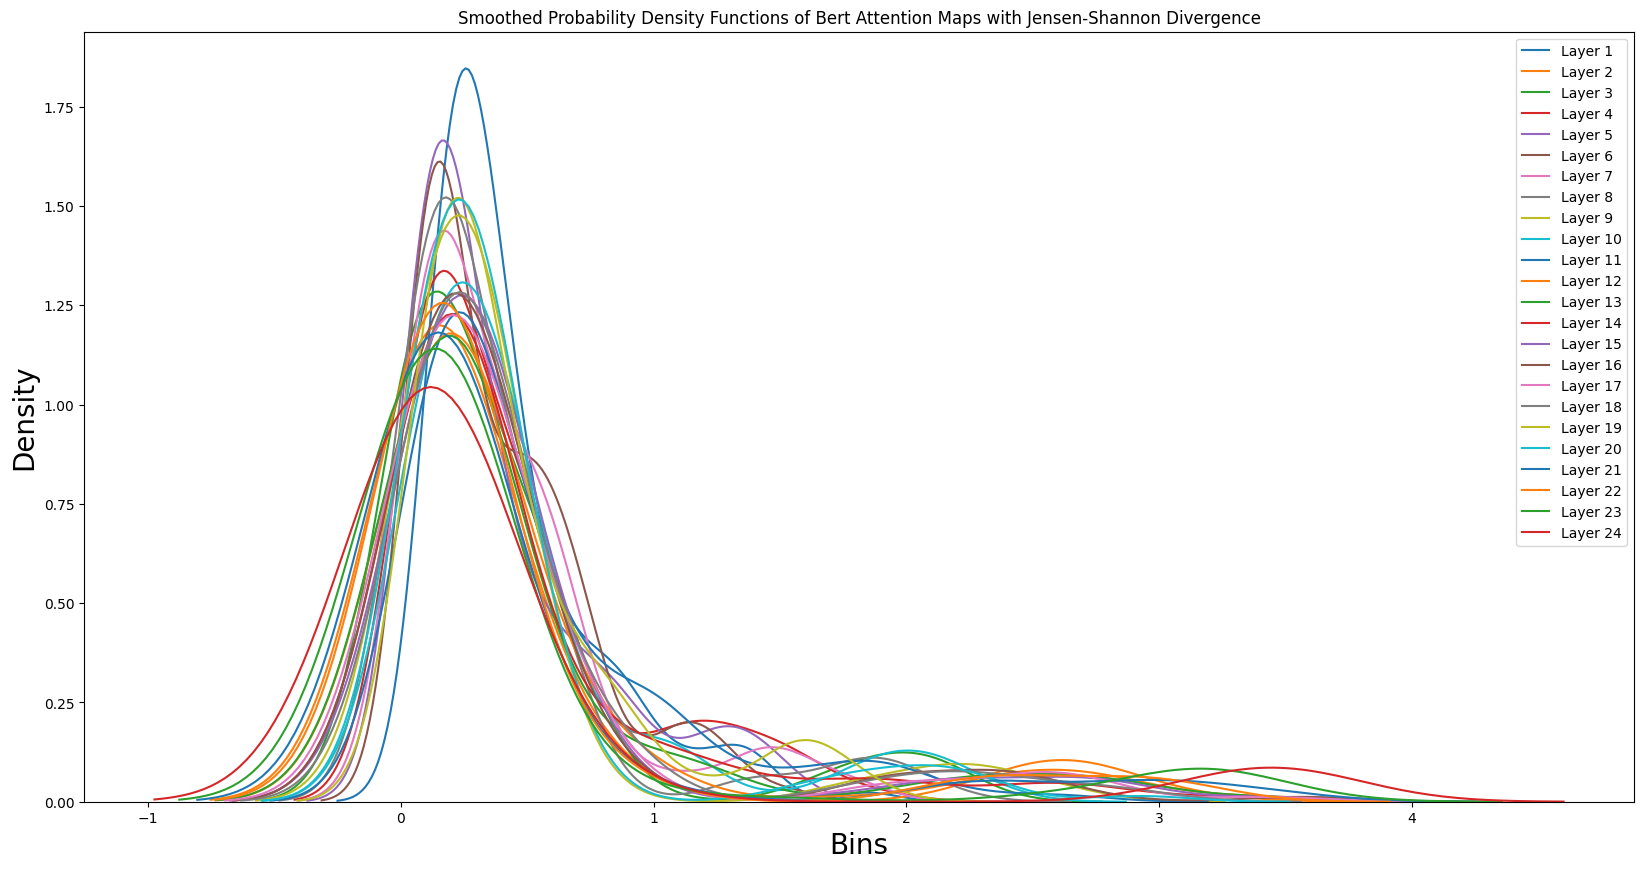

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# Assuming attention_maps is a list of attention map tensors for each layer
# Convert the list of tensors to numpy arrays and flatten them
flattened_maps = [map_tensor.detach().cpu().numpy().flatten() for map_tensor in bert_normed]

# Calculate PDF using Kernel Density Estimation for each layer
kde_list = [sns.kdeplot(map_array, bw_adjust=0.5, fill=False) for map_array in flattened_maps]

# Calculate JSD between each pair of layers (if needed)
jsd_matrix = np.zeros((len(flattened_maps), len(flattened_maps)))
for i in range(len(flattened_maps)):
    for j in range(i+1, len(flattened_maps)):
        jsd_matrix[i, j] = jensenshannon(flattened_maps[i], flattened_maps[j])

# Since JSD is symmetric, copy the upper triangle to the lower triangle
jsd_matrix = jsd_matrix + jsd_matrix.T

# Plotting
fsize=20
fig, ax = plt.subplots(figsize=(20, 10))
for i, kde in enumerate(kde_list):
    sns.kdeplot(flattened_maps[i], ax=ax, fill=False, common_norm=False, palette="crest", label=f'Layer {i+1}')
plt.xlabel('Bins',fontsize=fsize)
plt.ylabel('Density',fontsize=fsize)
plt.legend()
plt.title('Smoothed Probability Density Functions of Bert Attention Maps with Jensen-Shannon Divergence')
plt.show()

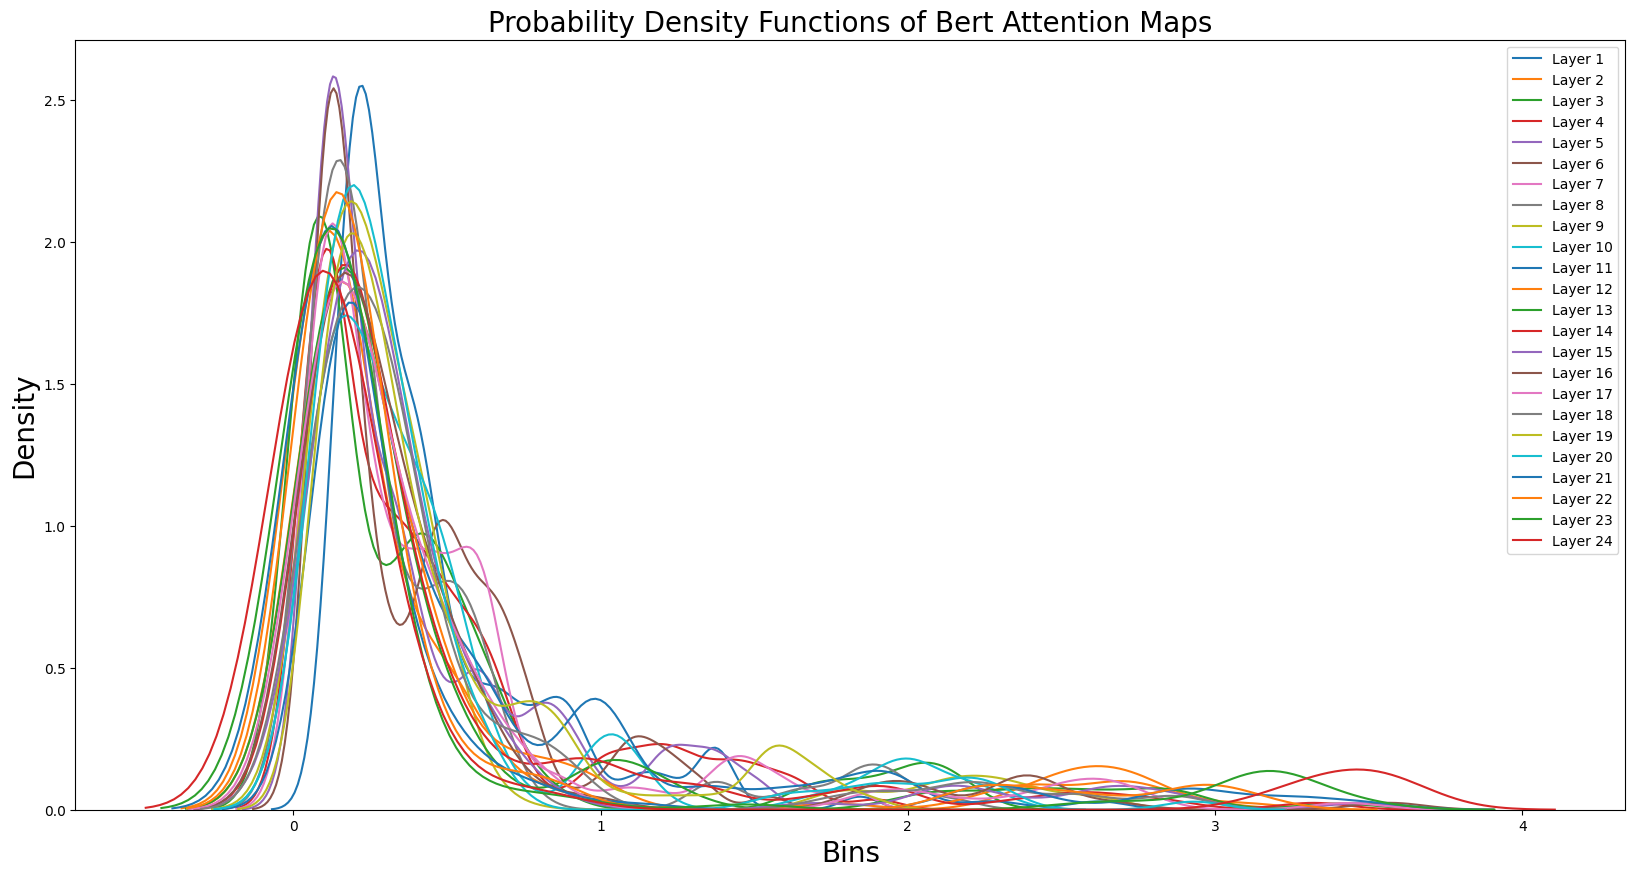

In [ ]:
fsize=20
fig, ax = plt.subplots(figsize=(20, 10))
for i,map_array in enumerate(flattened_maps):
  sns.kdeplot(map_array, bw_adjust=0.5, ax=ax, fill=False, common_norm=False, palette="crest", label=f'Layer {i+1}')
plt.xlabel('Bins',fontsize=fsize)
plt.ylabel('Density',fontsize=fsize)
plt.legend()
plt.title('Probability Density Functions of Bert Attention Maps',fontsize=fsize)
plt.show()

## Plotting JS Divergence Flan T5

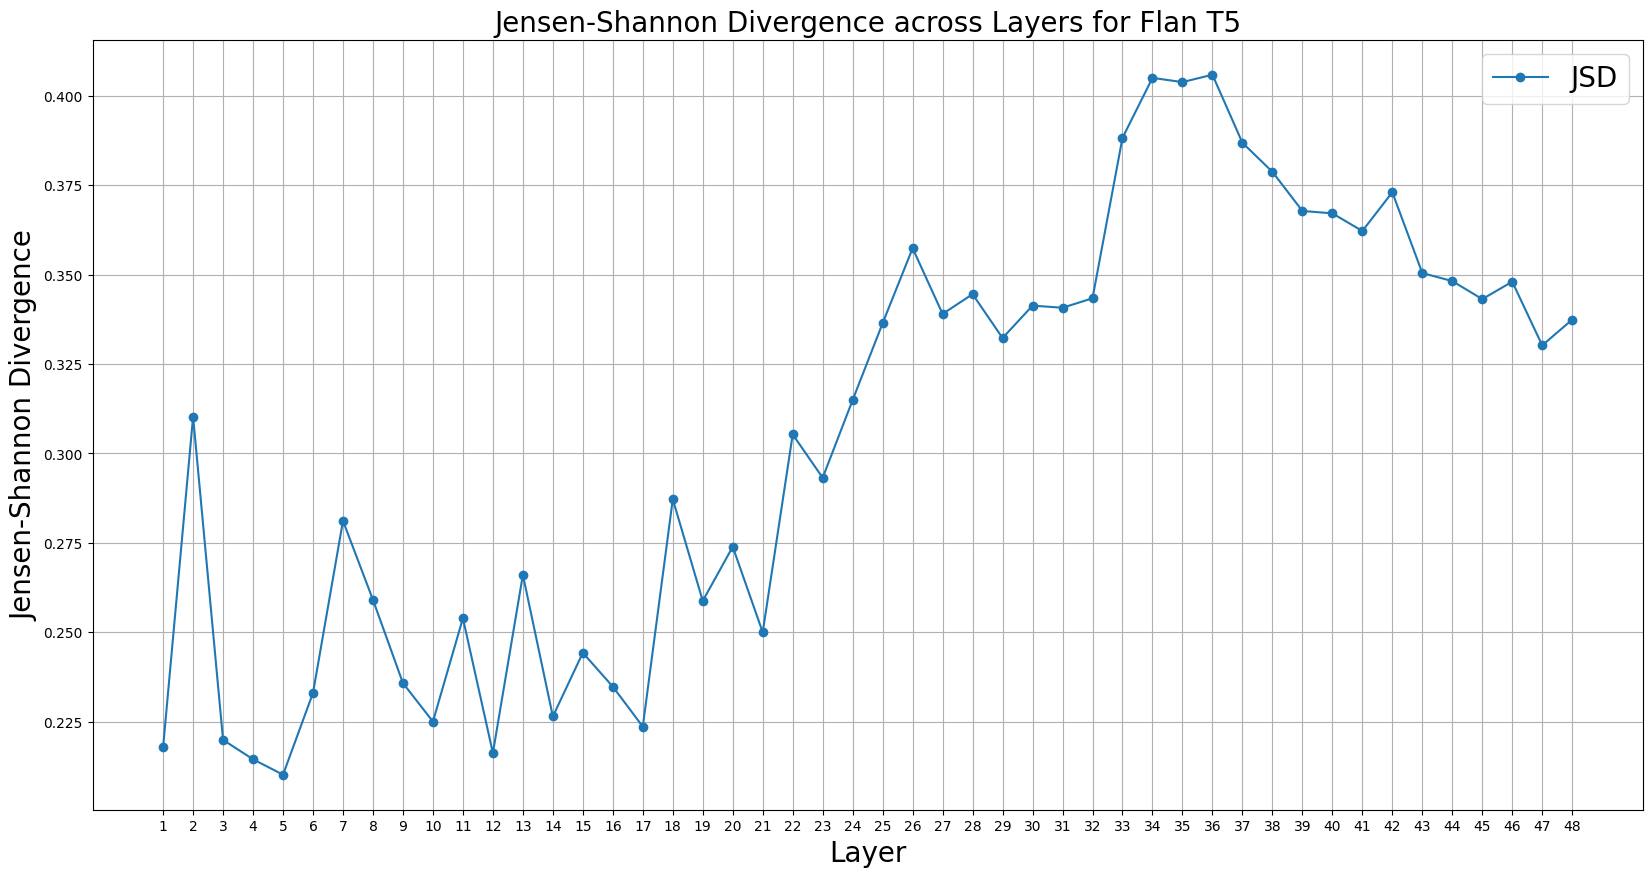

In [ ]:
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def calculate_js_divergence(map1, map2):
    # Flatten and normalize the attention maps to create probability distributions
    p = map1.flatten()
    p_norm = p/torch.sum(p) # p.sum()
    q = map2.flatten()
    q_norm = q/torch.sum(q) #q.sum()

    # Calculate the Jensen-Shannon divergence
    return jensenshannon(p_norm.detach().cpu().numpy(), q_norm.detach().cpu().numpy())

# Example usage:
# Assuming attention_maps is a list of your attention map tensors
# attention_maps = [layer1_map, layer2_map, ..., layer32_map]

# Select a reference map (e.g., first layer or an average map)
reference_map = torch.mean(t5_normed, dim=0)

# Calculate the JS divergence for each layer
js_divergences = [calculate_js_divergence(reference_map, map_i) for map_i in t5_normed]

# Plotting
fsize=20
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(js_divergences, marker='o')  # Using a marker for better visibility
plt.xticks(range(len(js_divergences)), [f'{i+1}' for i in range(len(js_divergences))])
plt.xlabel('Layer',fontsize=fsize)
plt.ylabel('Jensen-Shannon Divergence',fontsize=fsize)
plt.title('Jensen-Shannon Divergence across Layers for Flan T5',fontsize=fsize)
plt.legend(['JSD'],fontsize=fsize)
plt.grid(True)
plt.show()

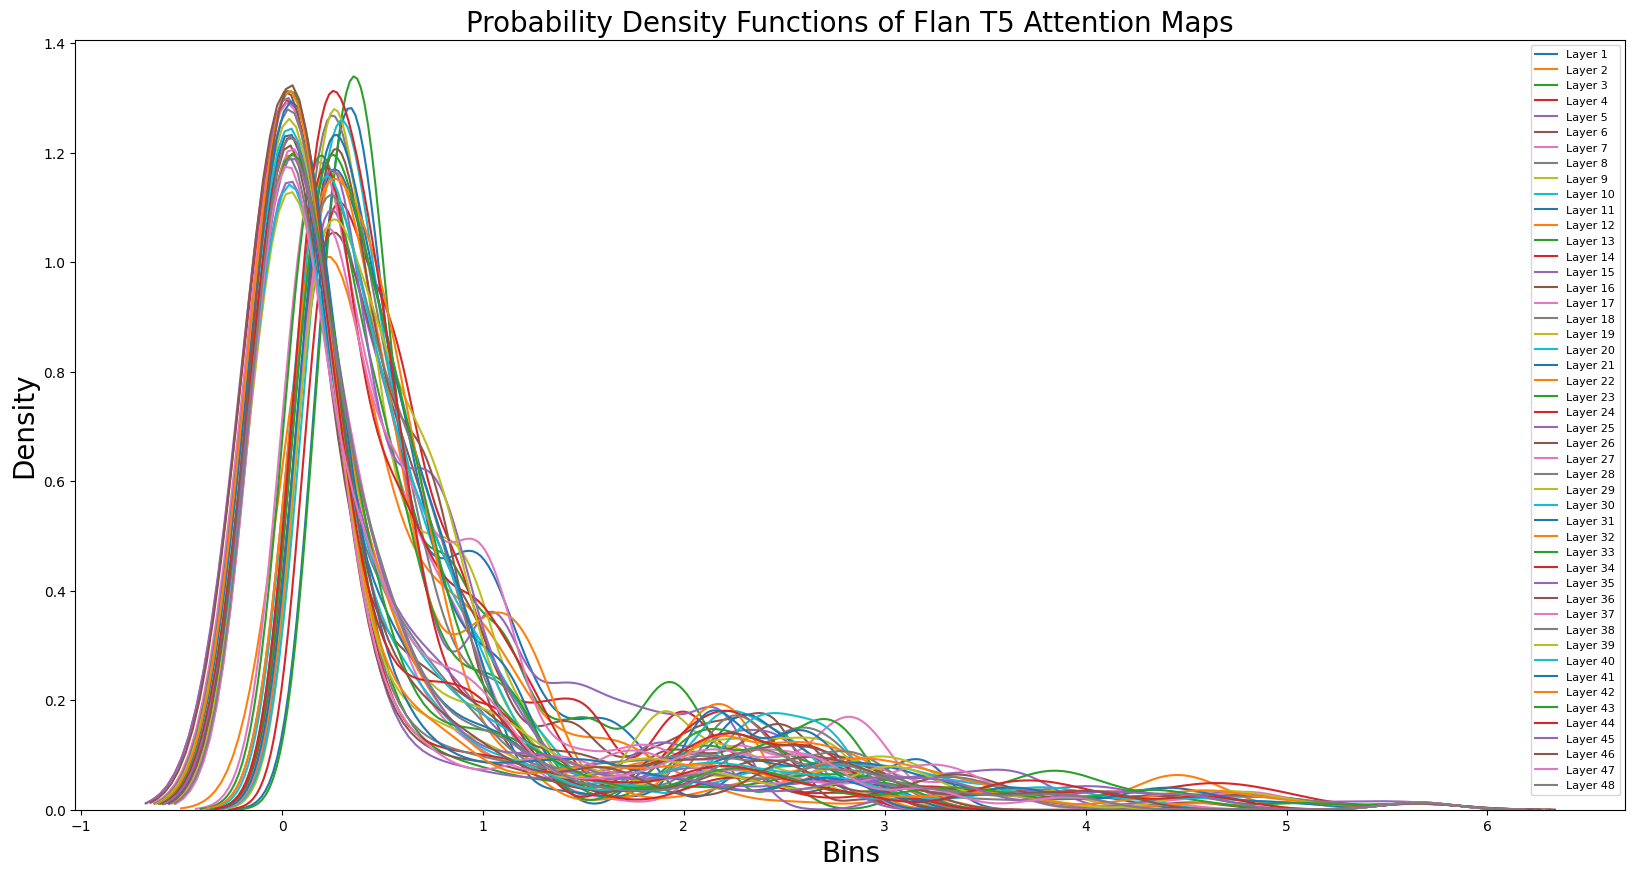

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# Assuming attention_maps is a list of attention map tensors for each layer
# Convert the list of tensors to numpy arrays and flatten them
flattened_maps = [map_tensor.detach().cpu().numpy().flatten() for map_tensor in t5_normed]


fsize=20
fig, ax = plt.subplots(figsize=(20, 10))
for i,map_array in enumerate(flattened_maps):
  sns.kdeplot(map_array, bw_adjust=0.5, ax=ax, fill=False, common_norm=False, palette="crest", label=f'Layer {i+1}')
plt.xlabel('Bins', fontsize=fsize)
plt.ylabel('Density', fontsize=fsize)
plt.legend(fontsize=8)
plt.title('Probability Density Functions of Flan T5 Attention Maps', fontsize=fsize)
plt.show()

# Section 7: Pretty Pictures

In [ ]:
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import warnings
warnings.filterwarnings('ignore')

def calculate_js_divergence(map1, map2):
    # Flatten and normalize the attention maps to create probability distributions
    p = map1.flatten()
    p_norm = p/torch.sum(p) # p.sum()
    q = map2.flatten()
    q_norm = q/torch.sum(q) #q.sum()

    # Calculate the Jensen-Shannon divergence
    return jensenshannon(p_norm.detach().cpu().numpy(), q_norm.detach().cpu().numpy())


def plot_js_divergence(maps_named):
  fig = plt.figure(figsize=(15,11))
  for idx,map_named in enumerate(maps_named):
    map_name, map_normed = map_named
    # Select a reference map (e.g., first layer or an average map)
    reference_map = torch.mean(map_normed, dim=0)
    # Calculate the JS divergence for each layer
    js_divergences = [calculate_js_divergence(reference_map, map_i) for map_i in map_normed]
    avg_jsd=sum(js_divergences)/len(js_divergences)
    title=map_name+'\n Average: {avg_jsd:.3f}'
    ax = fig.add_subplot(2,3, idx+1)
    plt.plot(js_divergences, marker='.')  # Using a marker for better visibility
    plt.xlabel("Layer")
    plt.ylabel("Divergence")
    plt.ylim(0,0.5)
    plt.title(title.format(avg_jsd=avg_jsd))
  plt.suptitle("Jensen Shannon divergences of each layer against reference")
  plt.tight_layout()
  plt.show()

def plot_js_divergence_sequential(maps_named):
  fig = plt.figure(figsize=(15,11))
  for idx,map_named in enumerate(maps_named):
    map_name, map_normed = map_named
    # Select a reference map (e.g., first layer or an average map)
    reference_map = torch.mean(map_normed, dim=0)
    # Calculate the JS divergence for each layer
    js_divergences = []
    for i in range(1,len(map_normed)):
      jsd_i=calculate_js_divergence(map_normed[i-1],map_normed[i])
      js_divergences.append(jsd_i)
    avg_jsd=sum(js_divergences)/len(js_divergences)
    title=map_name+'\n Average: {avg_jsd:.3f}'
    ax = fig.add_subplot(2,3, idx+1)
    plt.plot(js_divergences, marker='.')  # Using a marker for better visibility
    plt.xlabel("Layer")
    plt.ylabel("Divergence")
    plt.ylim(0,0.6)
    plt.title(title.format(avg_jsd=avg_jsd))
  plt.suptitle("Jensen Shannon divergences between sequential layers")
  plt.tight_layout()
  plt.show()

def plot_js_divergence_moving_avg(maps_named):
  fig = plt.figure(figsize=(15,11))
  for idx,map_named in enumerate(maps_named):
    map_name, map_normed = map_named
    # Select a reference map (e.g., first layer or an average map)
    reference_map = torch.mean(map_normed, dim=0)
    # Calculate the JS divergence for each layer
    js_divergences = []
    for i in range(3,len(map_normed)):
      reference_map=(map_normed[i-1]+map_normed[i-2]+map_normed[i-3])/3
      jsd_i=calculate_js_divergence(reference_map,map_normed[i])
      js_divergences.append(jsd_i)
    avg_jsd=sum(js_divergences)/len(js_divergences)
    title=map_name+'\n Average: {avg_jsd:.3f}'
    ax = fig.add_subplot(2,3, idx+1)
    plt.plot(js_divergences, marker='.')  # Using a marker for better visibility
    plt.xlabel("Layer")
    plt.ylabel("Divergence")
    plt.ylim(0,0.6)
    plt.title(title.format(avg_jsd=avg_jsd))
  plt.suptitle("Jensen Shannon divergences against moving average of 3 previous layers")
  plt.tight_layout()
  plt.show()

def plot_attention_pdf(maps_named, xlim=None, ylim=None):
  fig = plt.figure(figsize=(15,10))
  for idx,map_named in enumerate(maps_named):
    map_name, map_normed = map_named
    flattened_maps = [map_tensor.detach().cpu().numpy().flatten() for map_tensor in map_normed]
    ax = fig.add_subplot(2,3, idx+1)
    # Calculate PDF using Kernel Density Estimation for each layer
    kde_list = [sns.kdeplot(map_array, bw_adjust=0.5, fill=False) for map_array in flattened_maps]
    if xlim!=None:
      plt.xlim(xlim)
    if ylim!=None:
       plt.ylim(ylim)
    plt.title(map_name)
  plt.suptitle("Attention Distribution Across Layers")
  plt.show()

device='cuda'
mistral_attn = torch.load('mistral_attn.pt', map_location=torch.device(device))
falcon_attn = torch.load('falcon_attn.pt', map_location=torch.device(device))
bert_attn = torch.load('bert_attn_large.pt', map_location=torch.device(device))
t5_attn = torch.load('t5_attn.pt', map_location=torch.device(device))
rwkv_attn = torch.load('rwkv_attn.pt', map_location=torch.device(device))

if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

falcon_normed=norm_fn(torch.squeeze(falcon_attn), dim=1)
mistral_normed=norm_fn(torch.squeeze(mistral_attn), dim=1)
bert_normed=norm_fn(torch.squeeze(bert_attn), dim=1)
t5_normed=norm_fn(torch.squeeze(t5_attn), dim=1)
rwkv_normed=norm_fn(torch.squeeze(rwkv_attn), dim=1)

## JS Divergence across layers

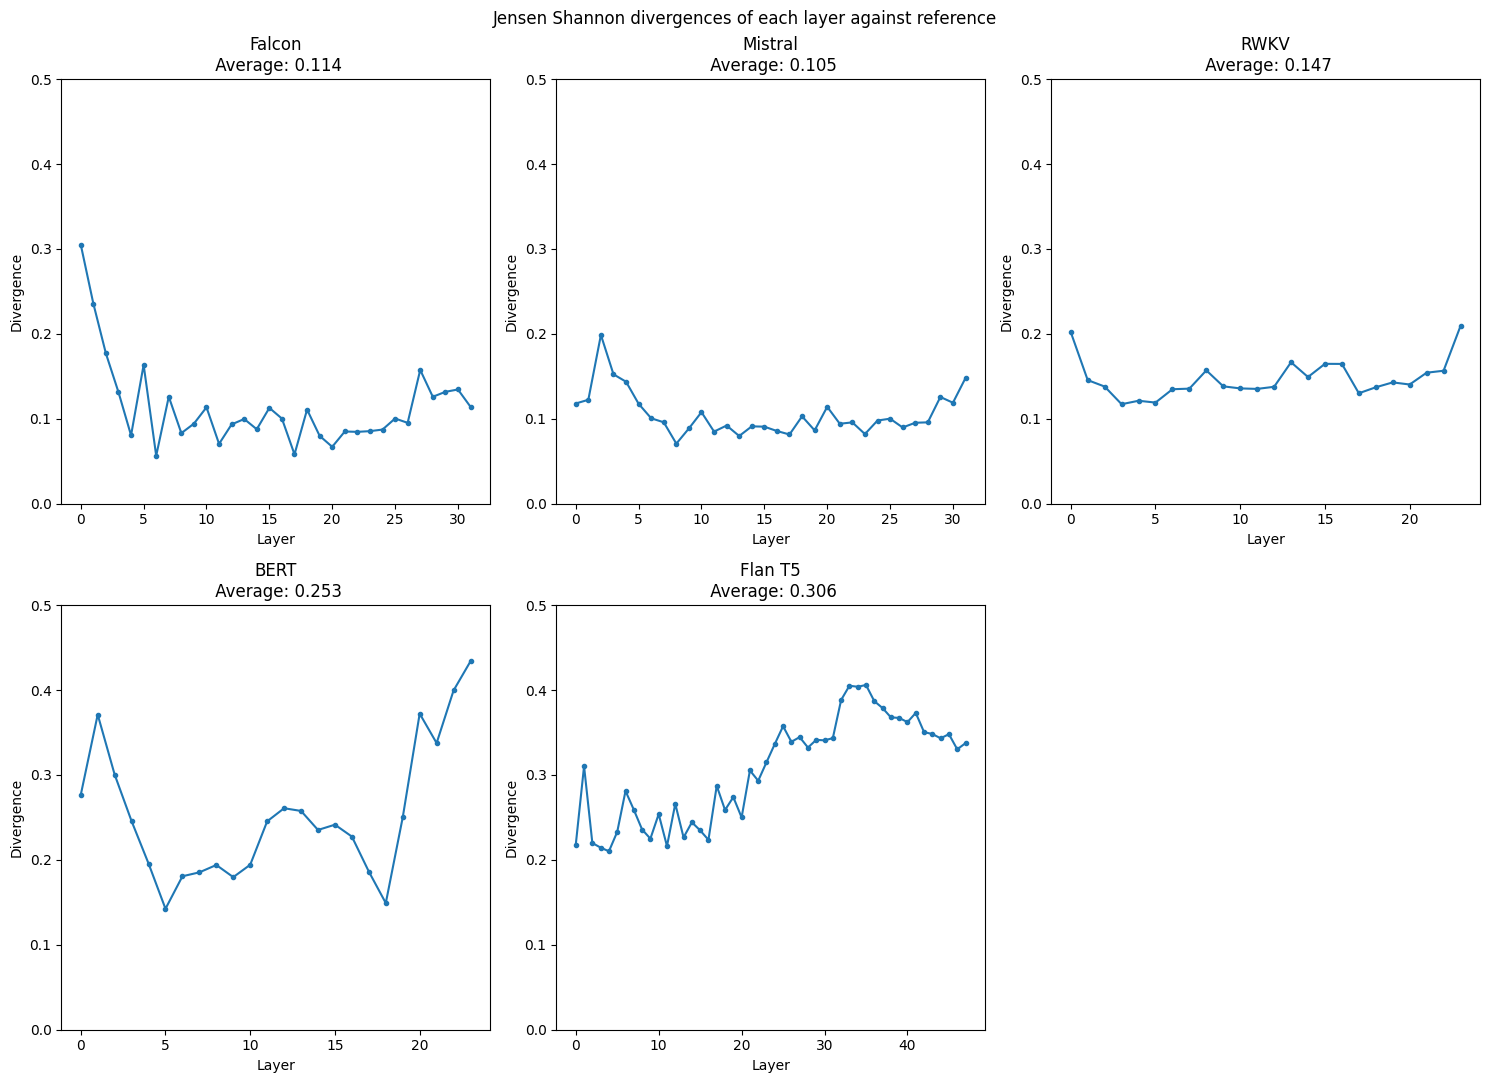

In [106]:
# Plotting
plot_js_divergence([("Falcon", falcon_normed),
                    ("Mistral", mistral_normed),
                    ("RWKV", rwkv_normed),
                    ("BERT", bert_normed),
                    ("Flan T5", t5_normed)])

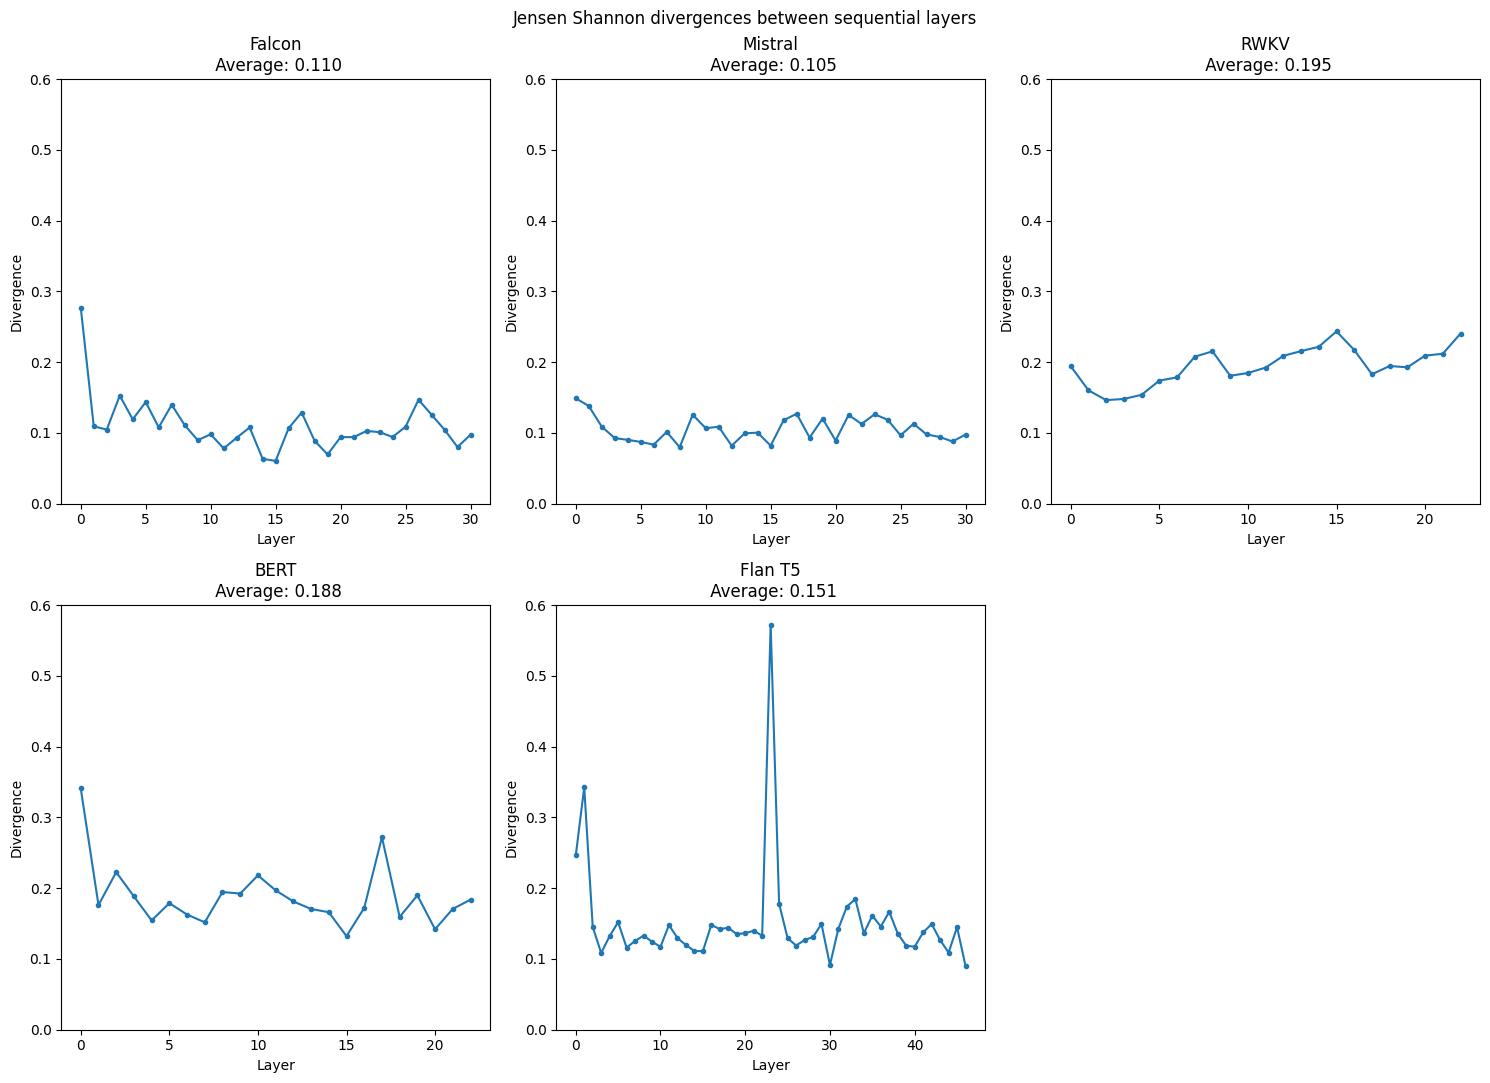

In [107]:
plot_js_divergence_sequential([("Falcon", falcon_normed),
                    ("Mistral", mistral_normed),
                    ("RWKV", rwkv_normed),
                    ("BERT", bert_normed),
                    ("Flan T5", t5_normed)])

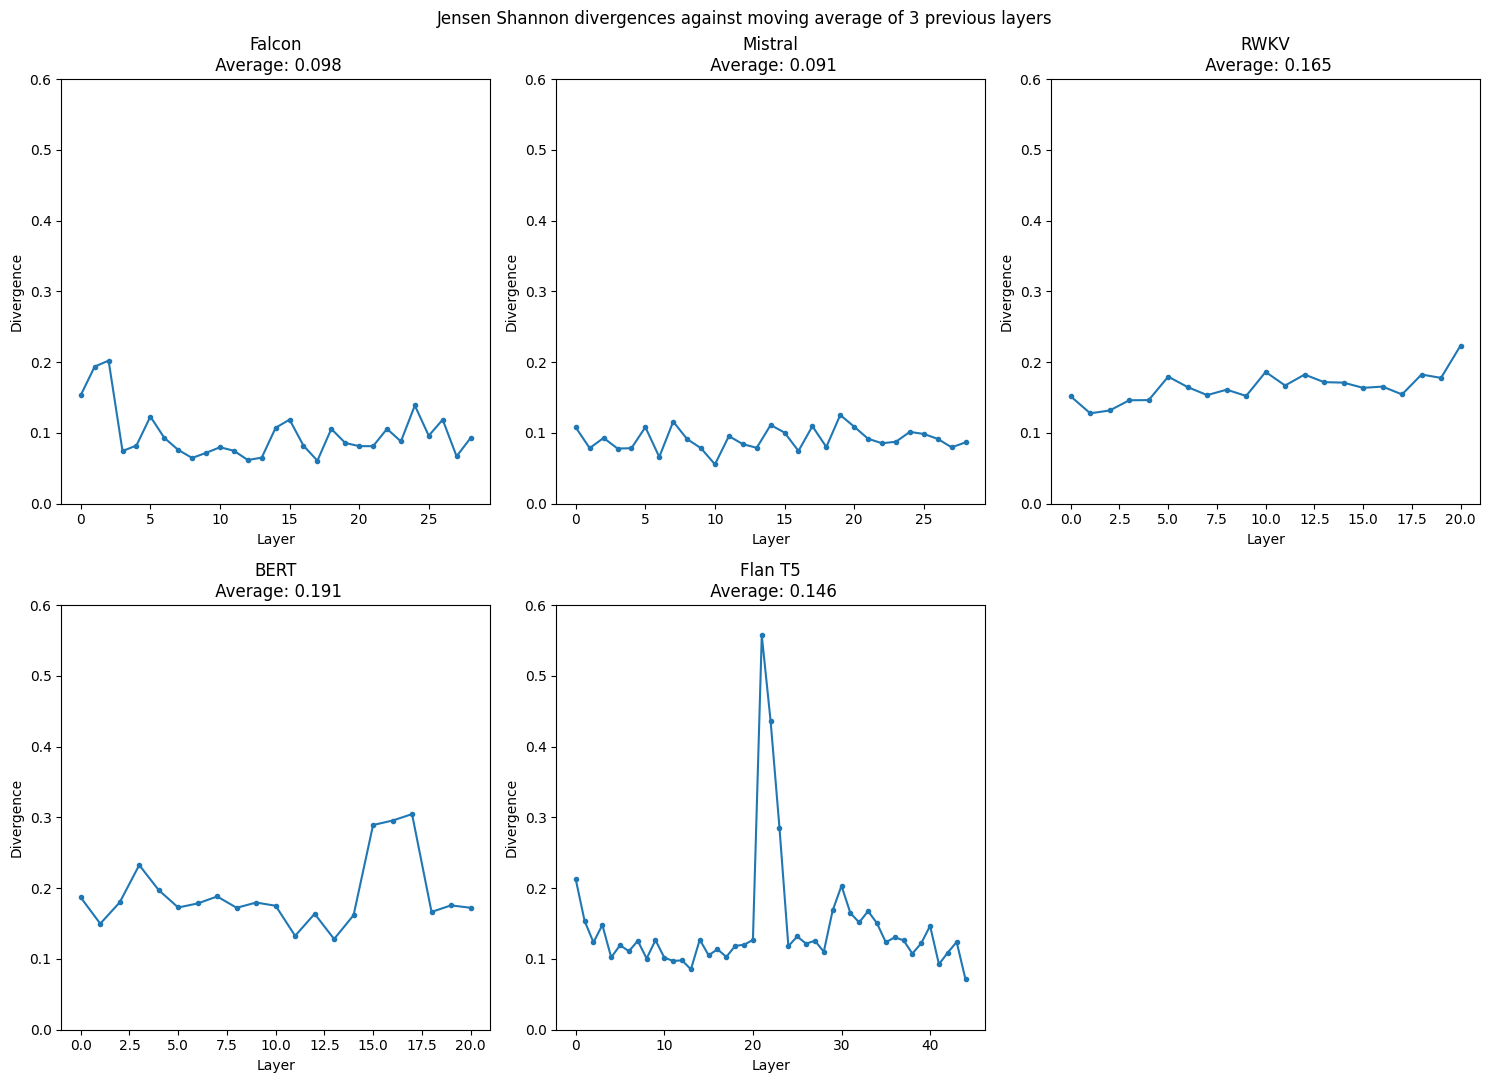

In [108]:
plot_js_divergence_moving_avg([("Falcon", falcon_normed),
                    ("Mistral", mistral_normed),
                    ("RWKV", rwkv_normed),
                    ("BERT", bert_normed),
                    ("Flan T5", t5_normed)])

## Attention PDF Across Layers

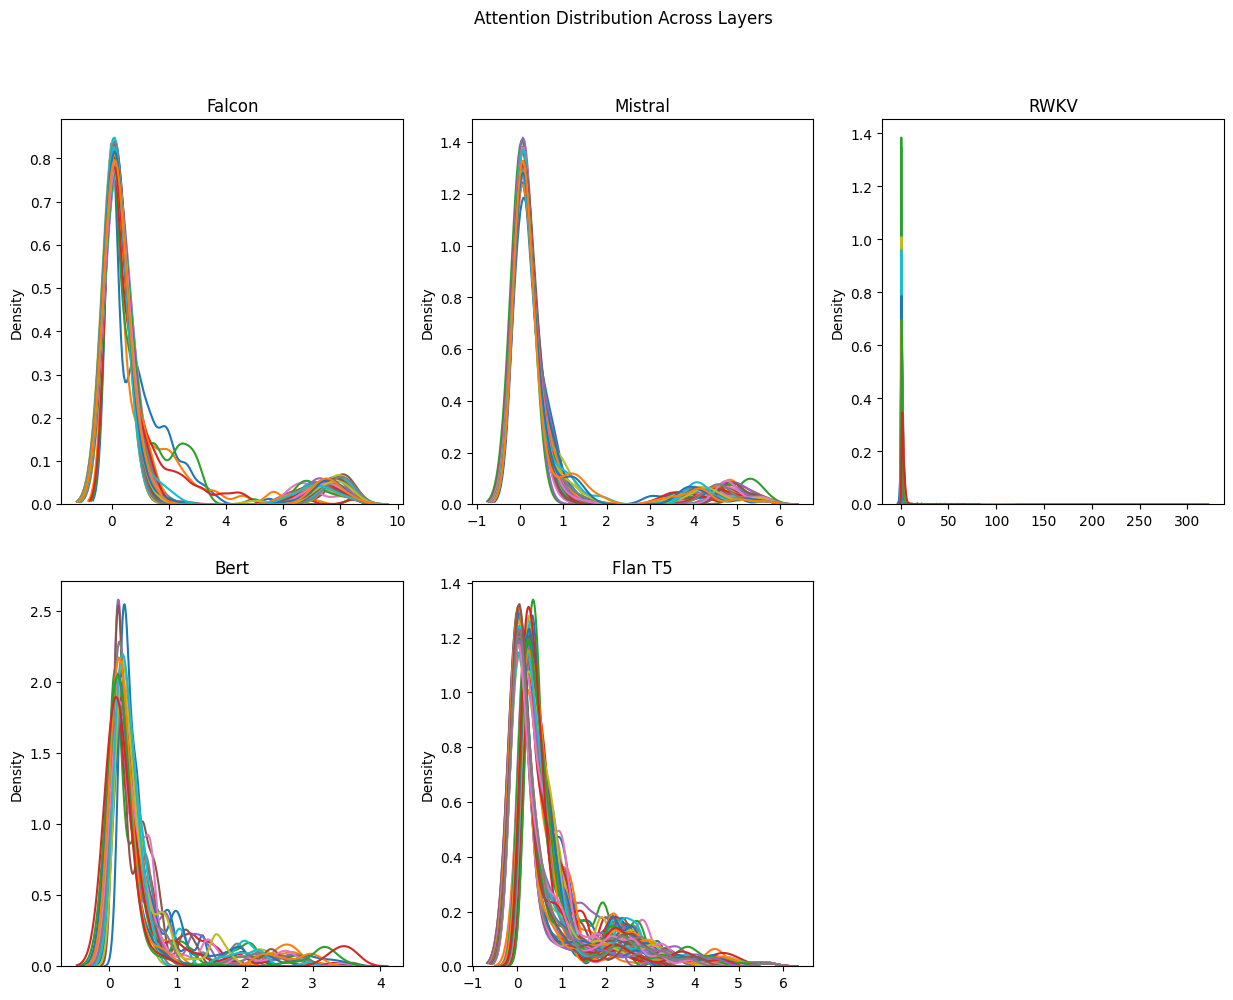

In [ ]:
# Plotting Unconstrained
plot_attention_pdf([("Falcon", falcon_normed),
                    ("Mistral", mistral_normed),
                    ("RWKV", rwkv_normed),
                    ("Bert", bert_normed),
                    ("Flan T5", t5_normed)])

## Attention Maps

In [ ]:
def visualize_scores(scores_mat, titles,tokenlist=None,suptitle=None):
    fig = plt.figure(figsize=(20, 5))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(1,3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        if tokenlist:
          ax.set_xticks(range(len(tokenlist[idx])))
          ax.set_yticks(range(len(tokenlist[idx])))
          ax.set_xticklabels(tokenlist[idx], fontdict=fontdict, rotation=90)
          ax.set_yticklabels(tokenlist[idx], fontdict=fontdict)
        # ax.set_xlabel('{} {}'.format(x_label_name, idx+1))
        ax.set_title(titles[idx])

        fig.colorbar(im, fraction=0.046, pad=0.04)
    if suptitle:
      plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

In [ ]:
mistral_tokens=['<s>','The','quick','brown','f','ox','j','umps','over','the','lazy','dog']
falcon_tokens=['The','quick','brown','fox','jumps','over','the','lazy','dog','.']
bert_tokens=['[CLS]','the','quick','brown','fox','jumps','over','the','lazy','dog','.','SEP']
t5_tokens=['The','quick','brown','','fox','jump','s','over','the','lazy','dog','.','</s>']

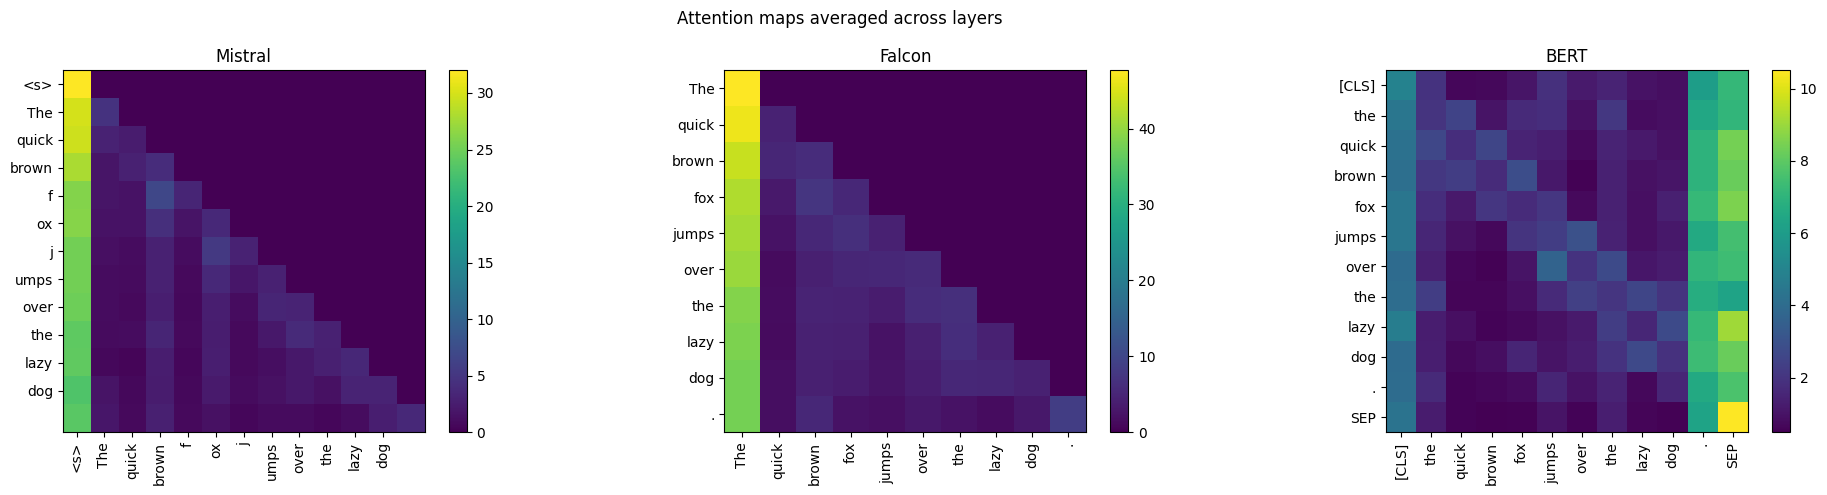

In [105]:
# visualize_token2token_scores(norm_fn(output_attn_all_t5, dim=2).squeeze().detach().cpu().numpy(), x_label_name='Layer')
attn_maps = [norm_fn(mistral_normed, axis=0).detach().cpu().numpy(),
             norm_fn(falcon_normed, axis=0).detach().cpu().numpy(),
             norm_fn(bert_normed, axis=0).detach().cpu().numpy()]
visualize_scores(attn_maps, ["Mistral","Falcon","BERT"],
                 tokenlist=[mistral_tokens,falcon_tokens,bert_tokens],
                 suptitle="Attention maps averaged across layers")

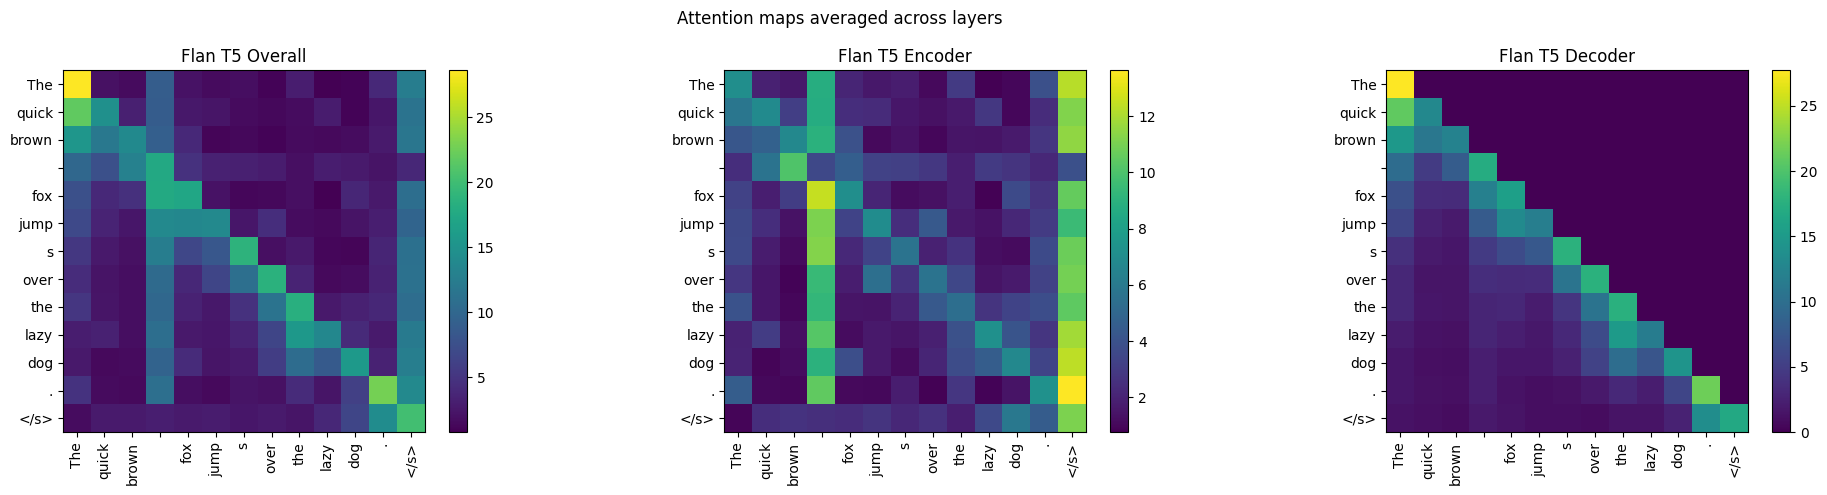

In [ ]:
t5_encoder = t5_normed[:23]
t5_decoder = t5_normed[24:]
attn_maps = [norm_fn(t5_normed, axis=0).detach().cpu().numpy(),
             norm_fn(t5_encoder, axis=0).detach().cpu().numpy(),
             norm_fn(t5_decoder, axis=0).detach().cpu().numpy()]
visualize_scores(attn_maps, ["Flan T5 Overall","Flan T5 Encoder","Flan T5 Decoder"],
                 tokenlist=[t5_tokens,t5_tokens,t5_tokens],
                 suptitle="Attention maps averaged across layers")

# Section 8: Visualizing Convexity Gap

In [ ]:
def calculate_js_divergence(map1, map2):
    # Flatten and normalize the attention maps to create probability distributions
    p = map1.flatten()
    p_norm = p/torch.sum(p) # p.sum()
    q = map2.flatten()
    q_norm = q/torch.sum(q) #q.sum()

    # Calculate the Jensen-Shannon divergence
    return jensenshannon(p_norm.detach().cpu().numpy(), q_norm.detach().cpu().numpy())

In [73]:
from scipy.spatial.distance import jensenshannon
def visualize_convexity_gap(matrix1, matrix2):
    """
    Visualize the convexity gap between two matrices.
    """
    # Convert numpy arrays to PyTorch tensors
    tensor1 = torch.tensor(matrix1, dtype=torch.float)
    tensor2 = torch.tensor(matrix2, dtype=torch.float)

    # Calculate the Jensen-Shannon Divergence
    js_divergence = calculate_js_divergence(tensor1, tensor2)

    # Convert to numpy for visualization
    js_divergence_np = js_divergence

    # Visualize using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(js_divergence_np, annot=True, cmap='viridis')
    plt.title('Convexity Gap Visualization')
    plt.show()


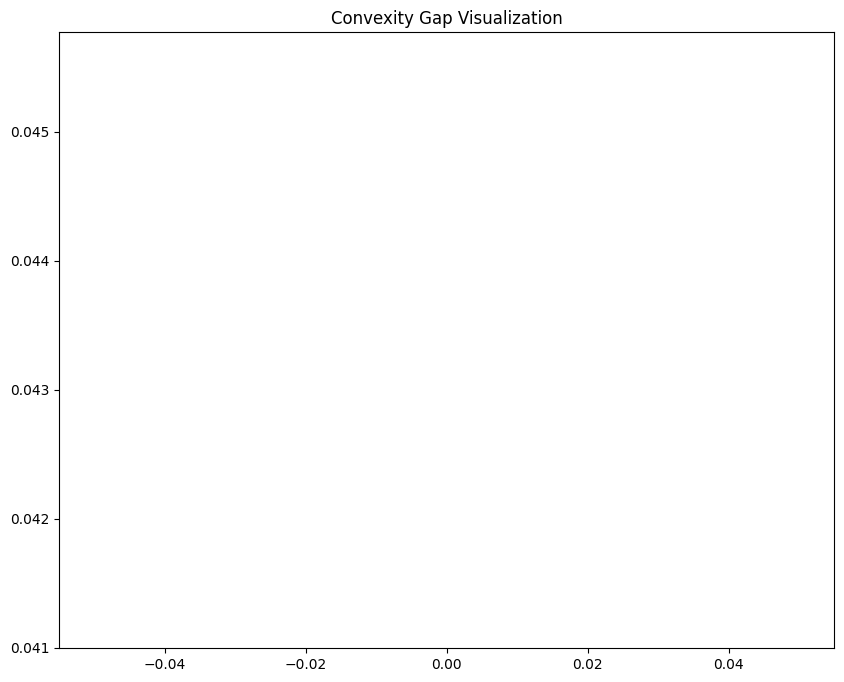

array(0.04338324, dtype=float32)

In [112]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

def jensen_shannon_divergence(p, q):
    """
    Compute the Jensen-Shannon Divergence between two probability distributions.
    """
    m = 0.5 * (p + q)
    return 0.5 * (torch.nn.functional.kl_div(p.log(), m) + torch.nn.functional.kl_div(q.log(), m))

def visualize_convexity_gap(matrix1, matrix2):
    """
    Visualize the convexity gap between two matrices.
    """
    # Convert numpy arrays to PyTorch tensors
    tensor1 = torch.tensor(matrix1, dtype=torch.float)
    tensor2 = torch.tensor(matrix2, dtype=torch.float)

    # Calculate the Jensen-Shannon Divergence
    js_divergence = jensen_shannon_divergence(tensor1, tensor2)

    # Convert to numpy for visualization
    js_divergence_np = js_divergence.numpy()

    # Visualize using a heatmap
    plt.figure(figsize=(10, 8))
    plt.plot(js_divergence_np)
    plt.title('Convexity Gap Visualization')
    plt.show()

    return js_divergence_np

# Example matrices
matrix1 = np.random.rand(10, 10)
matrix2 = np.random.rand(10, 10)

# Visualize
visualize_convexity_gap(matrix1, matrix2)

In [ ]:
reference_map = torch.mean(mistral_normed, dim=0)
visualize_convexity_gap(reference_map, mistral_normed)

ValueError: ignored

In [ ]:
calculate_js_divergence(reference_map, mistral_normed[0])

AttributeError: ignored

In [ ]:
def convexity_gap_figure(map_normed):
  reference_map = torch.mean(map_normed, dim=0)
  visualize_convexity_gap